# Santa's 2019 : Original Genetic Algorithm method

This Notebook contains : 
- main fonction to optimize schedule of santa tour 2019 KAGGLE competition 
- all functions to make genetic algo works

VERSIONS :
- V1.1: 03/02/2020 : @njit(parallel=True)
- V1.0: 03/02/2020 : update generate_crossing_prob (optimize perf.)


## Import

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from datetime import datetime
import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
from numba import njit, jit, prange

# to get computer name
import platform
import re

# For Figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

## Definitions

In [65]:
# Paths to folders/files
# KAGGLE
#PATH_INPUT = '/kaggle/input' #for kaggle
#PATH_TO_SAVE_DATA = '/kaggle/working' #for kaggle

# LOCAL
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"

# PROB FILE PATH
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'

## POP PATH
SAVE_POP = None
#SAVE_POP = '10R' # 10 ranges method
# path to pop df file id save pop is none.
PATH_DF_POP = PATH_TO_SAVE_DATA + '/' + \
   "df_pop_choices_10R_1000_fs10_rfm0.05_dc2.pkl"
#PATH_DF_POP = PATH_TO_SAVE_DATA + '/' + \
#    "df_pop1000_fs10_rfm0.01_dc4_rm0.2_nk_20_gen90000_s88162.pkl"

# DAY information (useless ?)
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

##########
## Hyper-parameters: DEFAULT

# from data 
CHOICE_RANGE_MIN = 0 # minimum choice number
CHOICE_RANGE_MAX = 10 # maximum choice number

# for POP 
NB_FIRST_SEED = 10 # best parent to create mutated first population
NB_FIRST_POP = 1000 # number of first population of choices 
DELTA_CHOICE_FIRST_POP = 2 # +/- delta choice of mutated first population 
R_FIRST_MUT = 0.05 # RATIO of mutation for first population

# for all generations
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
POW_SELECTION = 0.3 # power for slection during crossing
NB_BEST_KEEP = 10 # number of best indiv to keep at each epoch
NB_MAX_EPOCHS = 1000
DELTA_CHOICE = 1 # +/- delta choice of mutated for generation population
R_CROSSOVER = 1 # Crossover Ratio of pop for next generation 

# get computer name
COMPUTERNAME = platform.node()

# check if Google colab need Drive ?
if re.match("^/content", os.getcwd()):
    print("GOOGLE COLAB MODE")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.chdir("/content/drive/My Drive/OpenClassRooms/IML_projet_8"  + 
             "/code/santa-workshop-tour-2019")

# check DATA input folder
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [66]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

@njit
def find_choice_range_optim(choice_curr, delta_choice=DELTA_CHOICE):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    
    use external constant var : CHOICE_RANGE_MIN & CHOICE_RANGE_MAX
    '''
    #return max(choice_curr, CHOICE_RANGE_MIN)
    
    
    choice_min = min(max(CHOICE_RANGE_MIN, choice_curr - delta_choice), 
                          CHOICE_RANGE_MAX - 2 * delta_choice)
    choice_max = min(CHOICE_RANGE_MAX, 
                        max(CHOICE_RANGE_MIN + 2 * delta_choice, 
                        choice_curr + delta_choice)) + 1
    range_choice = np.arange(choice_min, choice_max)
    
    return range_choice


def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    
    use external constant var : arr_choice
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

@njit
def find_choice_from_day_optim(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    
    use external constant var : arr_choice
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
    
def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice    

@njit
def choose_day_prob_optim(choice_curr, fam_id):
    #def choose_day_prob_optim(choice_curr, fam_id, arr_choice=arr_choice):
    '''
    V1.1 : correction about no selection of days choices for choice 10 
    
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    
    use external constant vars : arr_choice & arr_prob_fam
    '''
    #choice_curr = np.array(choice_curr)
        
    idx_choice_10 = []
    for I in np.arange(choice_curr.shape[0]):
        if choice_curr[I] == 10:
            idx_choice_10.append(I)
            
    idx_choice_10 = np.array(idx_choice_10)
    
    vect_days_choice = []
    for J in np.arange(choice_curr.shape[0]):
        vect_days_choice.append(arr_choice[fam_id, 
                                           np.minimum(9, choice_curr[J])])
        
    vect_days_choice = np.array(vect_days_choice)
    #print("idx_choice_10 " , idx_choice_10)
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.arange(1, 101)
        vect_prob_10 = arr_prob_fam[fam_id].copy()
        vect_prob_10[arr_choice[fam_id]] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        #print("vect_prob_10 ",vect_prob_10)
        days_10 = rand_choice_nb(vect_all_days, size=nb_10,
                                  prob=vect_prob_10)
        #print("days_10 ", days_10)
        for i_day, indice in enumerate(idx_choice_10):
            vect_days_choice[indice] = days_10[i_day]         
        return vect_days_choice
    else:
        return vect_days_choice 

def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)


def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def generate_crossing(arr_pop_in):
    '''
    function to generate crossing
    2 parents give 2 children
    Crossing point is randomly chosen
    
    input the current poulation array
    
    return new array of whole population
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    arr_pop = arr_pop_in.copy()
    vect_indiv = np.arange(arr_pop.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    vect_fam = vect_fam[2:-2]
    
    # method 1 : each 2 parents create 2 children (by replacement)
    arr_pairs = np.random.choice(vect_indiv, replace=False,
                        size=(int(arr_pop.shape[0]/2), 2))
    
    
    # loop over pairs of indiv.
    for indice in np.arange(arr_pairs.shape[0]):
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop.shape[1]))
    
        # find parts of second new indiv
        vect_id_1_part_0 = arr_pop[id_1].take(np.arange(fam_id_cross))
        vect_id_1_part_1 = arr_pop[id_0].take(np.arange(fam_id_cross, 
                                                  arr_pop.shape[1])) 
    
        # replace 2 parents by 2 children
        arr_pop[id_0,:] = np.concatenate((vect_id_0_part_0, vect_id_0_part_1))
        arr_pop[id_1,:] = np.concatenate((vect_id_1_part_0, vect_id_1_part_1))
      
    return arr_pop



def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

def create_df_prob_day_fam_optim(df_prob_day, df_prob):
    '''
    Creation of probabilities for each families and each days
    
    info : Optimized version
    
    input : df_prob_day, df_prob
    ouput : df_prob_fam
    '''
    
    arr_prob_fam = np.zeros([data.shape[0], df_prob_day.shape[0]])
    arr_prob = np.array(df_prob)
    list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
    arr_data = np.array(data.filter(items=list_choice_all))
    for fam_id in np.arange(data.shape[0]):
        # give at first to each families the same day probabilities
        
        #df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        arr_prob_fam[fam_id] = df_prob_day["prob"].values
        # and add prob for each day choosen by families
        for choice in np.arange(df_prob.shape[1]-1): 
            prob_curr = arr_prob[family_size_dict[fam_id]-2, choice]
            day_curr = arr_data[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            arr_prob_fam[fam_id, day_curr-1] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        arr_prob_fam[fam_id] = \
            arr_prob_fam[fam_id] / arr_prob_fam[fam_id].sum()
        
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index, 
                              data = arr_prob_fam)
    
    return df_prob_fam



@njit#(parallel=True, fastmath=True)
def rand_choice_nb(arr, size=1, prob=None):
    """
    numba compatible vesrion of np.random.choice(arr, size=size, prob=prob)
    
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    
    source : https://github.com/numba/numba/issues/2539
    """
    if prob is not None:
        list_value=[]
        for I in prange(size):
            list_value.append(arr[np.searchsorted(np.cumsum(prob), 
                                                  np.random.random(), 
                                                  side="right")])
        return np.array(list_value)
    else:
        return np.random.choice(arr, size=size)




def find_max_same_indiv(arr_pop):
    '''
    Counts max number of same indiv among population
    return only max number of same indiv
    '''
    arr_unique, arr_counts = np.unique(arr_pop, axis=0, return_counts=True)
    nb_same_indiv = np.max(arr_counts) - 1
    return nb_same_indiv



def selection_prob(df_cost, df_pop=None, pow_selection=0.3, flag_ouput=False,
                   nb_best_keep = NB_BEST_KEEP):
    '''
    Calculate prob for selection of best indiv. among pop
    Can return also best individuates : df_best, and their cost : df_cost_best
    '''
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(df_cost.shape[0]+1,1,-1 )
    arr_select_prob = np.zeros(df_cost_sort.shape[0])
    arr_select_prob[df_cost_sort.index] = df_cost_sort["rank"].values
    arr_select_prob = (arr_select_prob)**POW_SELECTION
    arr_select_prob = arr_select_prob / np.sum(arr_select_prob)

    if flag_ouput:
        list_index_best = df_cost_sort.iloc[range(0,nb_best_keep)].index
        df_best = df_pop.loc[list_index_best]
        df_cost_best = df_cost.loc[list_index_best]
        return arr_select_prob, df_best, df_cost_best
    else:
        return arr_select_prob

def pop_choices_info(df_pop):
    '''
    
    Show information about population df_pop
    
    outputs :
    - df_choices  : assignation day for each families for all pop
    - df_des_choices : describe of df_dhoices
    -  std_mean = Mean Standard deviation over families for whole population 
    
    '''
    
    @njit
    def find_pop_choices(arr_pop):
        '''
        Determine all choices of the population, from days
        '''
        arr_choices = np.zeros((arr_pop.shape[0], arr_pop.shape[1]))*np.nan
        for fam_id in range(arr_pop.shape[1]):
            for indice in range(arr_pop.shape[0]):
                arr_choices[indice, fam_id] = \
                    find_choice_from_day_optim(arr_pop[indice, fam_id], fam_id)
        return arr_choices
    
    arr_choices = find_pop_choices(df_pop.values)   
    df_choices = pd.DataFrame(arr_choices.astype(np.int64), 
                              index = df_pop.index,
                              columns=df_pop.columns) 
    arr_choices = find_pop_choices(df_pop.values)   
    df_choices = pd.DataFrame(arr_choices.astype(np.int64), 
                              index = df_pop.index,
                              columns=df_pop.columns) 
    df_des_choices = df_choices.describe()
    std_mean = df_des_choices.loc["std"].mean()
    print("Mean Standard deviation over families for whole population : ", 
         std_mean)
    print("Info about std: ",df_des_choices.loc["std"].describe())
    return df_choices, df_des_choices, std_mean

def create_seek_ranges(nb_first_seed=NB_FIRST_SEED):
    
    '''create df_range : contains all path to seek optimum'''
    
    df_range = pd.DataFrame(index=range(0, nb_first_seed), 
                            columns=range(0, submission.shape[0]))

    df_range.loc[0] = np.array(range(0, submission.shape[0]))

    df_range.loc[1] = np.array(range(submission.index.max(), 
                                     submission.index.min()-1, -1))  
    # generate start points
    start_pt = np.linspace(0, submission.shape[0], 
                           num=int((NB_FIRST_SEED)/2)+1, dtype="int")
    start_pt = start_pt[1:-1]
    start_pt

    # create range order for seeking
    indice = 2
    for st_id, _ in enumerate(start_pt):
        df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                    submission.shape[0])), 
                   np.array(range(0, start_pt[st_id]))))

    indice = 6
    for st_id, _ in enumerate(start_pt):
        df_range.loc[indice+st_id] = \
            np.concatenate((range(start_pt[st_id], 0-1, -1), 
                    range(submission.shape[0]-1, start_pt[st_id], -1)))

    return df_range  

In [67]:
@njit(parallel=True, fastmath=True)
def generate_crossing_prob(arr_pop_in, p=None , n_indiv=None, r_cross=1):
    '''
    function to generate crossing indiv  (version with probabilities)
    V1.1 : add force create new child if same parents by changing parent
           and limitation to start - 1 end end - 1 for crossing point.
           
    time exec : 3.5ms 1000 children
    
    2 parents give 1 child
    
    Crossing point is randomly chosen
    
    input the current population array
    
    return new array of whole population
    
    r_cross is more a target of ratio of crossover individuates.
    if not enough children, then generate more than the ratio
    
    EXAMPLE : 
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],
                [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], 
                [5,6,6,6,6,9,9,9,9,5]])
    arr_prob_test = 1 / np.array([1,2,3,4,5])
    arr_prob_test = arr_prob_test / np.sum(arr_prob_test)
    arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=11)
    plt.plot(arr_test_new[0]-arr_test[1])
    
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly

    # check number of indiv : 
    nb_pop = arr_pop_in.shape[0]
    # calculate number of new children
    n_indiv_cross = int(n_indiv*r_cross)
    if n_indiv_cross == 0:
        n_indiv_cross = 1
    # if not enough to create n_indiv, add crossover indiv:
    if n_indiv > nb_pop + n_indiv_cross:
        n_indiv_cross = n_indiv - nb_pop
    #print("n_indiv_cross : ", n_indiv_cross) 
    # initialize output
    arr_pop = np.zeros((int(n_indiv), arr_pop_in.shape[1]), dtype=np.int64)
    #print('arr_pop.shape :', arr_pop.shape)
    
    # preparation for loop over pairs : 
    vect_parents = np.arange(arr_pop_in.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    # NOT replacing all part of parents : limit range
    vect_fam = vect_fam[1:-1]
    arr_pairs = np.zeros((int(n_indiv_cross), 2), dtype=np.int64)
    # create pairs : select best ones more frequently first
    for I in prange(int(arr_pairs.shape[0])):
        arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
        #arr_pairs[I] = np.random.choice(vect_parents, size=2)
        K=0
        # check and force to new children from same parents
        # patch dirty ! but njit doenst work with random choice prob 
        # & non replace...
        while (arr_pairs[I,0] == arr_pairs[I,1]) & (K < 1000):
            arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
            # test if same indiv : 
            while not(np.any(arr_pop_in[arr_pairs[I,0]] - \
                             arr_pop_in[arr_pairs[I,1]])) & (K < 1000):
                arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
                K=K+1
            K=K+1
            
    # for all pairs wanted as output  
    for indice in prange(int(arr_pairs.shape[0])):
        # indice of 2 parents
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop_in[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop_in[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop_in.shape[1]))
        # create 1 children 
        arr_pop[indice] = np.concatenate((vect_id_0_part_0, 
                                            vect_id_0_part_1))
    # if crossing not all pop
    if r_cross < 1:
        # keep some of best parents 
        nb_parents_keep = n_indiv - n_indiv_cross
        #print("nb_parents_keep: ", nb_parents_keep)
        #vect_parent_keep = rand_choice_nb(vect_parents, size=nb_parents_keep, 
        #                                  prob=p)
        # we keep only the best parents
        inv_ind_best = np.argsort(p)
        arr_pop_ranked = arr_pop_in[inv_ind_best, :]
        
        #print('inv_ind_best.shape: ', inv_ind_best.shape)
        #print('arr_pop_in red: ', arr_pop[n_indiv_cross:, :].shape)
        #print('arr_pop_ranked.shape red: ',  arr_pop_ranked[-nb_parents_keep:, :].shape)
        #print('arr_pop_ranked.shape: ', arr_pop_ranked.shape)
        arr_pop[n_indiv_cross:, :] = \
            arr_pop_ranked[-nb_parents_keep:, :]
        
        return arr_pop
    else:  
        return arr_pop
    
def boost_diff_browsing(arr_choice, best, arr_range):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    Forward/Backward
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    '''
    # Create baselines # optimized version
    t_fit_0 = time.time()
    # Create baselines # optimized version
    start_cost = cost_function_optim(best)
    print("Start cost: ", start_cost)
    
    # prepare output : best submission seeking in different range walk around
    arr_sub = np.zeros((arr_range.shape[0], best.shape[0])).astype(np.int64)
    arr_score = np.zeros(arr_range.shape[0])
    
    #new = best.copy()
    
    for indice in np.arange(arr_range.shape[0]):
    #for indice in df_range.index:
        # choose current range in df_range
        range_optim = arr_range[indice]
        #range_optim = df_range.loc[indice]

        # initiate first inviduate 
        new = best.copy()
        cost_best = start_cost

        # loop over each family with this current range       
        for fam_id in range_optim:
            # loop over each family choice
            for pick in range(10):
                day = arr_choice[fam_id, pick]
                temp = new.copy()
                temp[fam_id] = day # add in the new pick
                cost_curr = cost_function_optim(temp) # test cost
                if cost_curr < cost_best:
                    new = temp.copy()
                    cost_best = cost_curr
                    #print(f'...Baseline #{indice} current best Score: {cost_best}')
                
        print(f'Baseline #{indice} Score: {cost_best}')
        arr_sub[indice] = new
        arr_score[indice] = cost_best
        
        
    # timing
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)
        
    return arr_sub, arr_score

In [68]:
'''%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'''

'%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'

In [69]:
'''%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'''

'%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'

In [70]:
'''arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],
            [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], 
            [5,6,6,6,6,9,9,9,9,5]])
arr_prob_test = 1 / np.array([1,2,3,4,5])
arr_prob_test = arr_prob_test / np.sum(arr_prob_test)
%timeit arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=1000)'''


'arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],\n            [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], \n            [5,6,6,6,6,9,9,9,9,5]])\narr_prob_test = 1 / np.array([1,2,3,4,5])\narr_prob_test = arr_prob_test / np.sum(arr_prob_test)\n%timeit arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=1000)'

In [71]:
'''print('NUMBA NUM THREADS')
try:
    print(os.environ['NUMBA_NUM_THREADS'])
except:
    print(numba.config.NUMBA_DEFAULT_NUM_THREADS)'''

"print('NUMBA NUM THREADS')\ntry:\n    print(os.environ['NUMBA_NUM_THREADS'])\nexcept:\n    print(numba.config.NUMBA_DEFAULT_NUM_THREADS)"

In [72]:
'''@njit(parallel=False, fastmath=False)
def do_sum_parallel_fast(A):
    n = len(A)
    acc = 0.
    for i in prange(n):
        acc += np.sqrt(A[i])
    return acc

@njit(parallel=True)
def two_d_array_reduction_prod(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)

    for i in prange(n):
        result1 *= tmp

    return result1
'''

'@njit(parallel=False, fastmath=False)\ndef do_sum_parallel_fast(A):\n    n = len(A)\n    acc = 0.\n    for i in prange(n):\n        acc += np.sqrt(A[i])\n    return acc\n\n@njit(parallel=True)\ndef two_d_array_reduction_prod(n):\n    shp = (13, 17)\n    result1 = 2 * np.ones(shp, np.int_)\n    tmp = 2 * np.ones_like(result1)\n\n    for i in prange(n):\n        result1 *= tmp\n\n    return result1\n'

In [73]:
'''%timeit do_sum_parallel_fast(np.array([0,1,2,3]))'''

'%timeit do_sum_parallel_fast(np.array([0,1,2,3]))'

In [74]:
'''%timeit two_d_array_reduction_prod(10)'''

'%timeit two_d_array_reduction_prod(10)'

In [75]:
'''%timeit two_d_array_reduction_prod(10)'''

'%timeit two_d_array_reduction_prod(10)'

In [76]:
'''two_d_array_reduction_prod.parallel_diagnostics(level=4)'''

'two_d_array_reduction_prod.parallel_diagnostics(level=4)'

## Read in the family information and sample submission

In [77]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


,0,1,2,3,4,5,6,7,8,9
family_id,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28
1,26,4,82,5,11,47,38,6,66,61
2,100,54,25,12,27,82,10,89,80,33
3,2,95,1,96,32,6,40,31,9,59
4,53,1,47,93,26,3,46,16,42,39


In [78]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [79]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Prepare mutation function

In [80]:
#family_size_dict[fam_id]
arr_n_people = data["n_people"].values

@njit
def mutation_day_optim(day_curr, fam_id, nb_mut=1, flag_prob=False, 
                       arr_n_people=arr_n_people, delta_choice=DELTA_CHOICE):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    # time cpu = #1=4us & 1000=191us
    choice_curr = find_choice_from_day_optim(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range_optim(choice_curr, 
                                            delta_choice=delta_choice)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        #vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = arr_prob[arr_n_people[fam_id]-2].take(range_choices)
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = rand_choice_nb(range_choices, size=nb_mut, 
                                    prob=vect_prob)
                        #np.random.choice(range_choices, size=nb_mut,
                        #             p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("type choice_new: ", type(choice_new))
    return choose_day_prob_optim(choice_new, fam_id)



In [81]:
@njit(parallel=True, fastmath=False)
def fun_vect_mut(arr_pop_in, r_pop_mut=R_POP_MUT, r_mut=R_MUT, 
                 delta_choice=DELTA_CHOICE):
    '''
    Mutation of all population
    
    input arr_pop
    output new arr_pop
    
    Example : 
    
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])
    arr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))

    R_POP_MUT =1
    R_MUT =1
    DELTA_CHOICE = 2
    print("R_POP_MUT ", R_POP_MUT)
    print("R_MUT ", R_MUT)
    print("DELTA_CHOICE ", DELTA_CHOICE)
    %timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)
    
    # timeit : 342 µs ± 31.9 µs
    
    # timeit : 31 ms on pop = 1000,  R_POP=0.1 R_MUT=0.01 DELTA_CHOICE=2
    '''
    #print("fun_vect_mut : r_pop_mut: ", r_pop_mut)
    #print("fun_vect_mut : r_pop_mut: ", r_mut)
    #print("fun_vect_mut : delta_choice: ", delta_choice)
    arr_pop = arr_pop_in.copy()
    nb_mut = int(r_pop_mut*arr_pop.shape[0])
    # indice of mutated indiv.
    #indice_mut = np.random.choice(np.arange(arr_pop.shape[0]), size=nb_mut)
    indice_mut = np.random.permutation(arr_pop.shape[0])
    indice_mut = indice_mut[0:nb_mut]
    # number of family who mutate for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(r_mut*arr_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    #print("nb_mut: ", nb_mut)
    #print("nb_fam_mut: ", nb_fam_mut)
    # for each indiv to mutate, select a random group of families to mutate
    for idx_mut in prange(indice_mut.shape[0]):
        indice = indice_mut[idx_mut]
        fam_mut = np.random.choice(np.arange(arr_pop.shape[1]), size=nb_fam_mut)
        #fam_mut = np.random.permutation(arr_pop.shape[1]) # better but slower
        #fam_mut = fam_mut[0:nb_fam_mut] # better but slower
    
        # for each family to mutate, find a new day among their choices
        for idx_fam in np.arange(fam_mut.shape[0]):
            fam_id = fam_mut[idx_fam]
            arr_pop[indice, fam_id] = mutation_day_optim(
                            arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                            flag_prob=True, delta_choice=delta_choice)[0]

    return arr_pop


In [82]:

'''%timeit fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'''


'%timeit fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'

In [83]:
'''fun_vect_mut.parallel_diagnostics(level=4)'''

'fun_vect_mut.parallel_diagnostics(level=4)'

In [84]:
'''print(R_POP_MUT)
print(R_MUT)
print(DELTA_CHOICE)'''

'print(R_POP_MUT)\nprint(R_MUT)\nprint(DELTA_CHOICE)'

In [85]:

'''arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])
arr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))

R_POP_MUT =1
R_MUT =1
DELTA_CHOICE = 2
print("R_POP_MUT ", R_POP_MUT)
print("R_MUT ", R_MUT)
print("DELTA_CHOICE ", DELTA_CHOICE)
%timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'''

'arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],\n                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])\narr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))\n\nR_POP_MUT =1\nR_MUT =1\nDELTA_CHOICE = 2\nprint("R_POP_MUT ", R_POP_MUT)\nprint("R_MUT ", R_MUT)\nprint("DELTA_CHOICE ", DELTA_CHOICE)\n%timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'

In [86]:
'''fam_id = 0
day_curr = 100
%timeit mutation_day(day_curr, fam_id, 1)'''

'fam_id = 0\nday_curr = 100\n%timeit mutation_day(day_curr, fam_id, 1)'

In [87]:
try:
    arr_pop_mut = fun_vect_mut(arr_pop)
except:
    pass

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [88]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function

### First version : from baseline

In [89]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost
    
    if flag_prompt:
        return penalty, accounting_cost, daily_occupancy
    else:
        return penalty

### Optimized numba version



Reference : 
Adapted version of https://www.kaggle.com/xhlulu/santa-s-2019-faster-cost-function-24-s

In [90]:
"""
V 2.0 : 17/01/2020 : G.LANG : limitation when use  accounting_matrix
# About this kernel

The `cost_function` in this kernel is roughly 600x faster compared to the original kernel. 
Each function call takes roughly 24 µs.

## Quick Start

1. Import this utility file: File > Add utility script > Search Notebooks > *Type this notebook name*

2. Copy the code below to get started:
```
# Imports
import pandas as pd
import numpy as np

# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

# Load Data
base_path = '/kaggle/input/santa-workshop-tour-2019/'
data = pd.read_csv(base_path + 'family_data.csv', index_col='family_id')
submission = pd.read_csv(base_path + 'sample_submission.csv', index_col='family_id')

# Build your "cost_function"
cost_function = build_cost_function(data)

# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
```

A longer example is provided at the end.


## Note

Starting in V12, I decided to make this an utility script instead of a regular notebook.
I think this is a better use of this kernel, since you can now directly import this into
your project and use it just like an API, instead of copy-pasting the lengthy code.

I think that make this into a script forces me to keep the code cleaner.

## Reference

* (Excellent) Original Kernel: https://www.kaggle.com/inversion/santa-s-2019-starter-notebook
* First kernel that had the idea to use Numba: https://www.kaggle.com/nickel/250x-faster-cost-function-with-numba-jit
* Another great cost function optimization: https://www.kaggle.com/sekrier/fast-scoring-using-c-52-usec
* More modular output for intermediate function: https://www.kaggle.com/nickel/santa-s-2019-fast-pythonic-cost-23-s
"""

from functools import partial

## Intermediate Helper Functions
def _build_choice_array(data, n_days):
    choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
    choice_array_num = np.full((data.shape[0], n_days + 1), -1)

    for i, choice in enumerate(choice_matrix):
        for d, day in enumerate(choice):
            choice_array_num[i, day] = d
    
    return choice_array_num


def _precompute_accounting(max_day_count, max_diff):
    accounting_matrix = np.zeros((max_day_count+1, max_diff+1))
    # Start day count at 1 in order to avoid division by 0
    for today_count in range(1, max_day_count+1):
        for diff in range(max_diff+1):
            accounting_cost = (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0)
            accounting_matrix[today_count, diff] = max(0, accounting_cost)
    
    return accounting_matrix


def _precompute_penalties(choice_array_num, family_size):
    penalties_array = np.array([
        [
            0,
            50,
            50 + 9 * n,
            100 + 9 * n,
            200 + 9 * n,
            200 + 18 * n,
            300 + 18 * n,
            300 + 36 * n,
            400 + 36 * n,
            500 + 36 * n + 199 * n,
            500 + 36 * n + 398 * n
        ]
        for n in range(family_size.max() + 1)
    ])
    
    penalty_matrix = np.zeros(choice_array_num.shape)
    N = family_size.shape[0]
    for i in range(N):
        choice = choice_array_num[i]
        n = family_size[i]
        
        for j in range(penalty_matrix.shape[1]):
            penalty_matrix[i, j] = penalties_array[n, choice[j]]
    
    return penalty_matrix


@njit
def _compute_cost_fast(prediction, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    """
    Do not use this function. Please use `build_cost_function` instead to 
    build your own "cost_function".
    """
    N = family_size.shape[0]
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
    penalty = 0
    
    # Looping over each family; d is the day, n is size of that family
    for i in range(N):
        n = family_size[i]
        d = prediction[i]
        
        daily_occupancy[d] += n
        penalty += penalty_matrix[i, d]

    # for each date, check total occupancy 
    # (using soft constraints instead of hard constraints)
    # Day 0 does not exist, so we do not count it
    relevant_occupancy = daily_occupancy[1:]
    
    # patch : G.L. 12/01/2020 - begins
    incorrect_occupancy =  (relevant_occupancy > MAX_OCCUPANCY) | \
        (relevant_occupancy < MIN_OCCUPANCY)
    for inc_curr in incorrect_occupancy:
        if inc_curr:
            #print("inc_curr", inc_curr)
            penalty += 100000000
    #print(incorrect_occupancy)
    # patch : G.L. 12/01/2020 - ends

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days_array[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days_array, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days_array[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        # patch G.L. : 17/01/2020 : limit inputs
        today_count_lim = max(MIN_OCCUPANCY, min(MAX_OCCUPANCY, today_count))
        diff_lim = max(0, min(N_DAYS, diff))
        accounting_cost += accounting_matrix[today_count_lim, diff_lim]

        yesterday_count = today_count
    #print("penalty: ", penalty)   
    #print("accounting_cost: ", accounting_cost)
    return penalty, accounting_cost, daily_occupancy

def build_cost_function(data, N_DAYS=100, MAX_OCCUPANCY=300, MIN_OCCUPANCY=125):
    """
    data (pd.DataFrame): 
        should be the df that contains family information. Preferably load it from "family_data.csv".
    """
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)

    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY, 
                                               max_diff=MAX_OCCUPANCY)
    # patch G.L. 12/01/2020 - ends
    
    # Partially apply `_compute_cost_fast` so that the resulting partially applied
    # function only requires prediction as input. E.g.
    # Non partial applied: score = _compute_cost_fast(prediction, family_size, days_array, ...)
    # Partially applied: score = cost_function(prediction)
    def cost_function(prediction: np.ndarray) -> float:
        penalty, accounting_cost, daily_occupancy = _compute_cost_fast(
            prediction=prediction,
            family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS
        )
        #print('penalty', penalty)
        #print('accounting_cost', accounting_cost)
        return penalty + accounting_cost
    
    return cost_function  

# Build your "cost_function"
cost_function_optim = build_cost_function(data)

In [91]:
'''%timeit cost_function_optim(arr_pop[0])'''

'%timeit cost_function_optim(arr_pop[0])'

### eval_cost_vect_optim (build)

In [92]:
# version build : AVEC les parametres dans le build 

@njit(parallel=True, fastmath=False)
def _eval_cost_vect_optim(arr_pop, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    
    info : speed up to max prop to cost optim  : 24e-6s by cost calculation.
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    # time execution : parallel 17 ms ald 24ms for 1000 cost evaluation 

    '''
    #@njit
    def _compute_cost_fast_intern(prediction):
        """
        Do not use this function. Please use `build_cost_function` instead to 
        build your own "cost_function".
        """
        N = family_size.shape[0]
        # We'll use this to count the number of people scheduled each day
        daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
        penalty = 0

        # Looping over each family; d is the day, n is size of that family
        for i in range(N):
            n = family_size[i]
            d = prediction[i]

            daily_occupancy[d] += n
            penalty += penalty_matrix[i, d]

        # for each date, check total occupancy 
        # (using soft constraints instead of hard constraints)
        # Day 0 does not exist, so we do not count it
        relevant_occupancy = daily_occupancy[1:]

        # patch : G.L. 12/01/2020 - begins
        a = (relevant_occupancy > MAX_OCCUPANCY)
        b = (relevant_occupancy < MIN_OCCUPANCY)
        incorrect_occupancy = a | b 
        for inc_curr in incorrect_occupancy:
            if inc_curr:
                #print("inc_curr", inc_curr)
                penalty += 100000000
        #print(incorrect_occupancy)
        # patch : G.L. 12/01/2020 - ends

        # Calculate the accounting cost
        # The first day (day 100) is treated special
        init_occupancy = daily_occupancy[days_array[0]]
        accounting_cost = (init_occupancy - 125.0) / \
            400.0 * init_occupancy**(0.5)
        # using the max function because the soft constraints 
        # might allow occupancy to dip below 125
        accounting_cost = max(0, accounting_cost)

        # Loop over the rest of the days_array, keeping track of previous count
        yesterday_count = init_occupancy
        for day in days_array[1:]:
            today_count = daily_occupancy[day]
            diff = abs(today_count - yesterday_count)
            # patch G.L. : 17/01/2020 : limit inputs
            today_count_lim = max(MIN_OCCUPANCY, 
                                  min(MAX_OCCUPANCY, today_count))
            diff_lim = max(0, min(N_DAYS, diff))
            accounting_cost += accounting_matrix[today_count_lim, diff_lim]

            yesterday_count = today_count
        #print("penalty: ", penalty)   
        #print("accounting_cost: ", accounting_cost)
        return penalty, accounting_cost, daily_occupancy
    
    
    arr_score = np.zeros(arr_pop.shape[0])
    
    for indice in prange(arr_pop.shape[0]):
        # patch to accelerate _compute_cost_fast_intern fct (do a copy)
        arr_curr = arr_pop[indice].copy()
        penalty, accounting_cost, daily_occupancy  = \
            _compute_cost_fast_intern(arr_curr)
        arr_score[indice] = penalty + accounting_cost
         
    return  arr_score


def build_eval_cost_vect_optim(data, N_DAYS=100, MAX_OCCUPANCY=300, 
                                    MIN_OCCUPANCY=125):
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)
    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY,
                                       max_diff=MAX_OCCUPANCY)
    
    def my_eval_cost_vect_optim(arr_pop):
        
        arr_score = _eval_cost_vect_optim(arr_pop, 
            family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS)
    
        return arr_score
    
    return my_eval_cost_vect_optim

eval_cost_vect_optim = build_eval_cost_vect_optim(data)

In [93]:
'''%timeit eval_cost_vect_optim(arr_pop)'''

'%timeit eval_cost_vect_optim(arr_pop)'

In [94]:
'''%timeit eval_cost_vect_optim(arr_pop)'''

'%timeit eval_cost_vect_optim(arr_pop)'

In [95]:

'''arr_pop = np.array(df_pop)
t_0 = time.time()
arr_score = eval_cost_vect_optim(arr_pop)
print("Timing: ", time.time()-t_0)
df_cost_test = pd.DataFrame(data=arr_score, columns=["cost"])
df_cost_test.sort_values(by="cost").head(10)'''



'arr_pop = np.array(df_pop)\nt_0 = time.time()\narr_score = eval_cost_vect_optim(arr_pop)\nprint("Timing: ", time.time()-t_0)\ndf_cost_test = pd.DataFrame(data=arr_score, columns=["cost"])\ndf_cost_test.sort_values(by="cost").head(10)'

In [96]:
'''np.count_nonzero(df_cost_test["cost"].values - df_cost["cost"].values)'''

'np.count_nonzero(df_cost_test["cost"].values - df_cost["cost"].values)'

In [97]:
'''%timeit arr_score = eval_cost_vect_optim(arr_pop)'''

'%timeit arr_score = eval_cost_vect_optim(arr_pop)'

In [98]:
'''t_0 = time.time()
arr_curr = arr_pop[0].copy()
for indice in range(1000):
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\narr_curr = arr_pop[0].copy()\nfor indice in range(1000):\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [99]:
'''t_0 = time.time()
for indice in range(1000):
    cost_function_optim(arr_pop[indice])
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    cost_function_optim(arr_pop[indice])\nprint("Timing: ", time.time()-t_0)'

In [100]:
'''t_0 = time.time()
for indice in range(1000):
    cost_function_optim(arr_pop[indice,:])
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    cost_function_optim(arr_pop[indice,:])\nprint("Timing: ", time.time()-t_0)'

In [101]:
'''t_0 = time.time()
for indice in range(1000):
    arr_curr = arr_pop[indice].copy()
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    arr_curr = arr_pop[indice].copy()\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [102]:
'''t_0 = time.time()
for arr_curr in arr_pop:
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor arr_curr in arr_pop:\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [103]:
'''arr_pop_0 = arr_pop[0].copy()'''

'arr_pop_0 = arr_pop[0].copy()'

In [104]:
'''arr_pop_0.dtype'''

'arr_pop_0.dtype'

In [105]:
'''%timeit cost_function_optim(arr_pop_0)'''

'%timeit cost_function_optim(arr_pop_0)'

In [106]:
'''%timeit cost_function_optim(arr_best)'''

'%timeit cost_function_optim(arr_best)'

### Boost optim (build)

In [107]:
# version build : AVEC les parametres dans le build 

@njit
def _boost_diff_browsing_optim(best, arr_range, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    
    info : speed up to max prop to cost optim  : 24e-6s by cost calculation.
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    speed exec : 10.8 s for 10 ranges.

    '''
    #@njit
    def _compute_cost_fast_intern(prediction):
        """
        Do not use this function. Please use `build_cost_function` instead to 
        build your own "cost_function".
        """
        N = family_size.shape[0]
        # We'll use this to count the number of people scheduled each day
        daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
        penalty = 0

        # Looping over each family; d is the day, n is size of that family
        for i in range(N):
            n = family_size[i]
            d = prediction[i]

            daily_occupancy[d] += n
            penalty += penalty_matrix[i, d]

        # for each date, check total occupancy 
        # (using soft constraints instead of hard constraints)
        # Day 0 does not exist, so we do not count it
        relevant_occupancy = daily_occupancy[1:]

        # patch : G.L. 12/01/2020 - begins
        a = (relevant_occupancy > MAX_OCCUPANCY)
        b = (relevant_occupancy < MIN_OCCUPANCY)
        incorrect_occupancy = a | b 
        for inc_curr in incorrect_occupancy:
            if inc_curr:
                #print("inc_curr", inc_curr)
                penalty += 100000000
        #print(incorrect_occupancy)
        # patch : G.L. 12/01/2020 - ends

        # Calculate the accounting cost
        # The first day (day 100) is treated special
        init_occupancy = daily_occupancy[days_array[0]]
        accounting_cost = (init_occupancy - 125.0) / \
            400.0 * init_occupancy**(0.5)
        # using the max function because the soft constraints 
        # might allow occupancy to dip below 125
        accounting_cost = max(0, accounting_cost)

        # Loop over the rest of the days_array, keeping track of previous count
        yesterday_count = init_occupancy
        for day in days_array[1:]:
            today_count = daily_occupancy[day]
            diff = abs(today_count - yesterday_count)
            # patch G.L. : 17/01/2020 : limit inputs
            today_count_lim = max(MIN_OCCUPANCY, 
                                  min(MAX_OCCUPANCY, today_count))
            diff_lim = max(0, min(N_DAYS, diff))
            accounting_cost += accounting_matrix[today_count_lim, diff_lim]

            yesterday_count = today_count
        #print("penalty: ", penalty)   
        #print("accounting_cost: ", accounting_cost)
        return penalty, accounting_cost, daily_occupancy
    
    
    # Create baselines # optimized version
    penalty, accounting_cost, daily_occupancy  = _compute_cost_fast_intern(best)
    start_cost = penalty + accounting_cost
    #start_cost = cost_function_optim(best)
    print("Start cost: ", start_cost)
    
    # prepare output : best submission seeking in different range walk around
    arr_sub = np.zeros((arr_range.shape[0], best.shape[0])).astype(np.int64)
    arr_score = np.zeros(arr_range.shape[0])
    new = best.copy() # TEST
    for indice in np.arange(arr_range.shape[0]):

        # initiate first inviduate 
        #new = best.copy() # TEST
        cost_best = start_cost
        
        # choose current range in df_range
        range_optim = arr_range[indice]
        # loop over each family with this current range       
        for fam_id in range_optim:
            # loop over each family choice
            for pick in range(10):
                day = arr_choice[fam_id, pick]
                temp = new.copy()
                temp[fam_id] = day # add in the new pick
        
                penalty, accounting_cost, daily_occupancy = \
                    _compute_cost_fast_intern(temp) #test cost
                cost_curr =  penalty + accounting_cost
                #cost_curr = cost_function_optim(temp)
                # if best cost found save it
                if cost_curr < cost_best:
                    new = temp.copy()
                    cost_best = cost_curr
                    #print("Current best cost: ", cost_best)

        arr_sub[indice] = new
        arr_score[indice] = cost_best
        print("Score: ", cost_best)
          
    return arr_sub, arr_score


def build_boost_diff_browsing_optim(data, N_DAYS=100, MAX_OCCUPANCY=300, 
                                    MIN_OCCUPANCY=125):
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)
    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY,
                                       max_diff=MAX_OCCUPANCY)
    
    def my_boost_diff_browsing_optim(best, arr_range):
        
        arr_sub, arr_score = _boost_diff_browsing_optim(best, arr_range, 
                                                        family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS)
    
        return arr_sub, arr_score
    
    return my_boost_diff_browsing_optim

boost_diff_browsing_optim = build_boost_diff_browsing_optim(data)

In [108]:
'''submission = pd.read_csv(fpath, index_col='family_id')
best = submission['assigned_day'].values
%time boost_diff_browsing_optim(best, arr_range)'''

"submission = pd.read_csv(fpath, index_col='family_id')\nbest = submission['assigned_day'].values\n%time boost_diff_browsing_optim(best, arr_range)"

## Explore day occupancy

In [73]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

,all_choices,first_choices,mid_choices,last_choices
1,11568,4391,4449,2728
2,1806,501,729,576
3,3607,1021,1526,1060
4,3872,1148,1585,1139
5,3907,1181,1544,1182


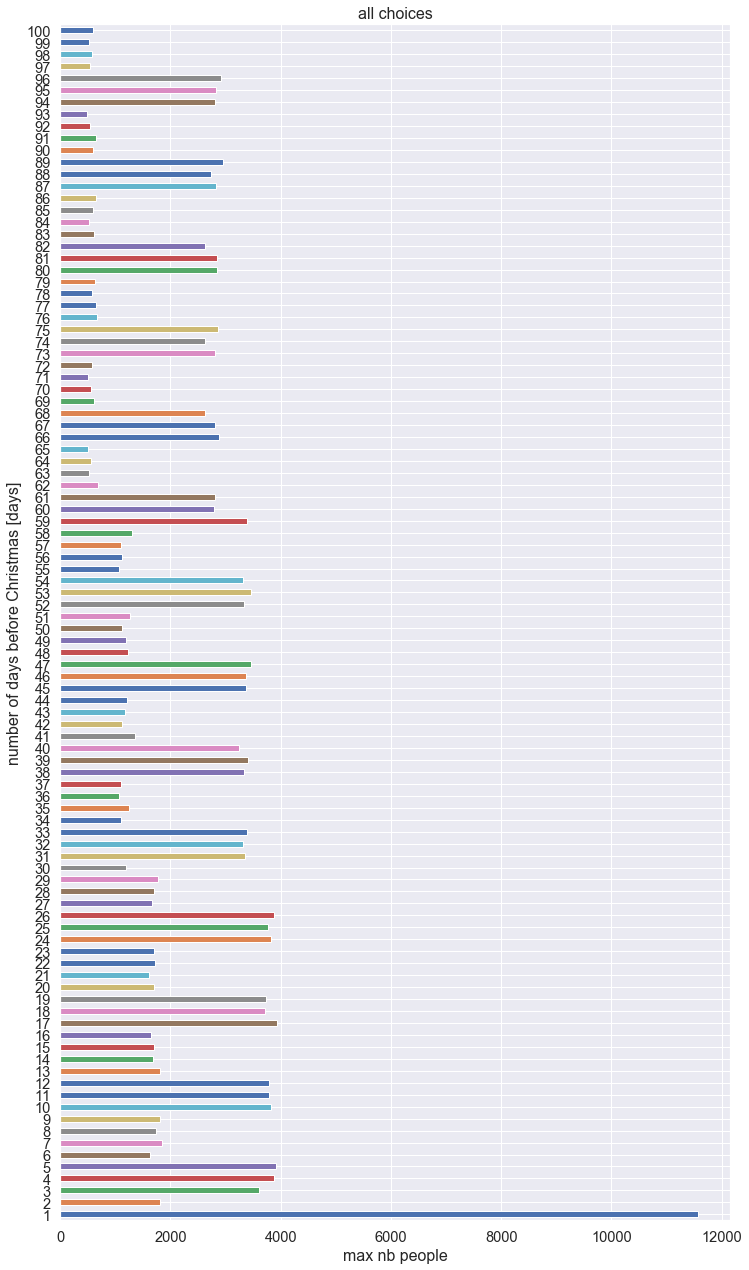

In [74]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

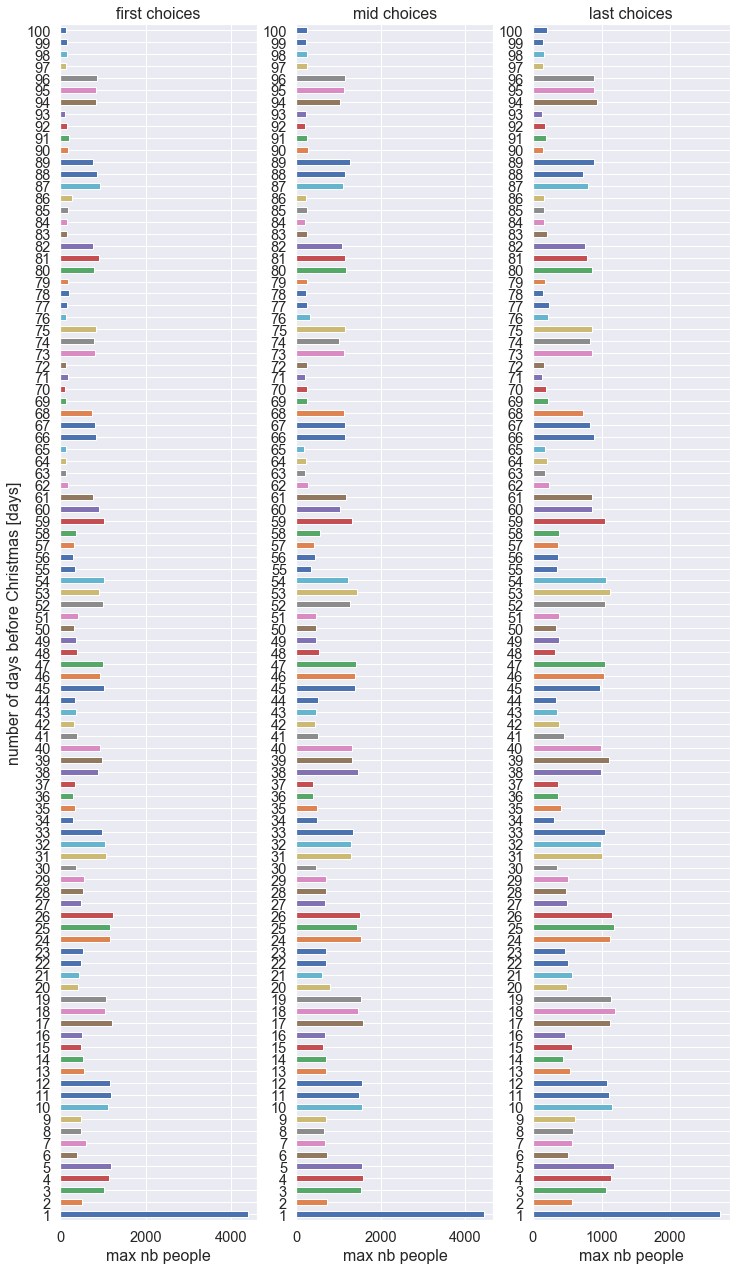

In [75]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [76]:
df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [77]:
df_prob_day.head()

,all_choices,prob
1,11568,0.001098
2,1806,0.007036
3,3607,0.003523
4,3872,0.003282
5,3907,0.003252


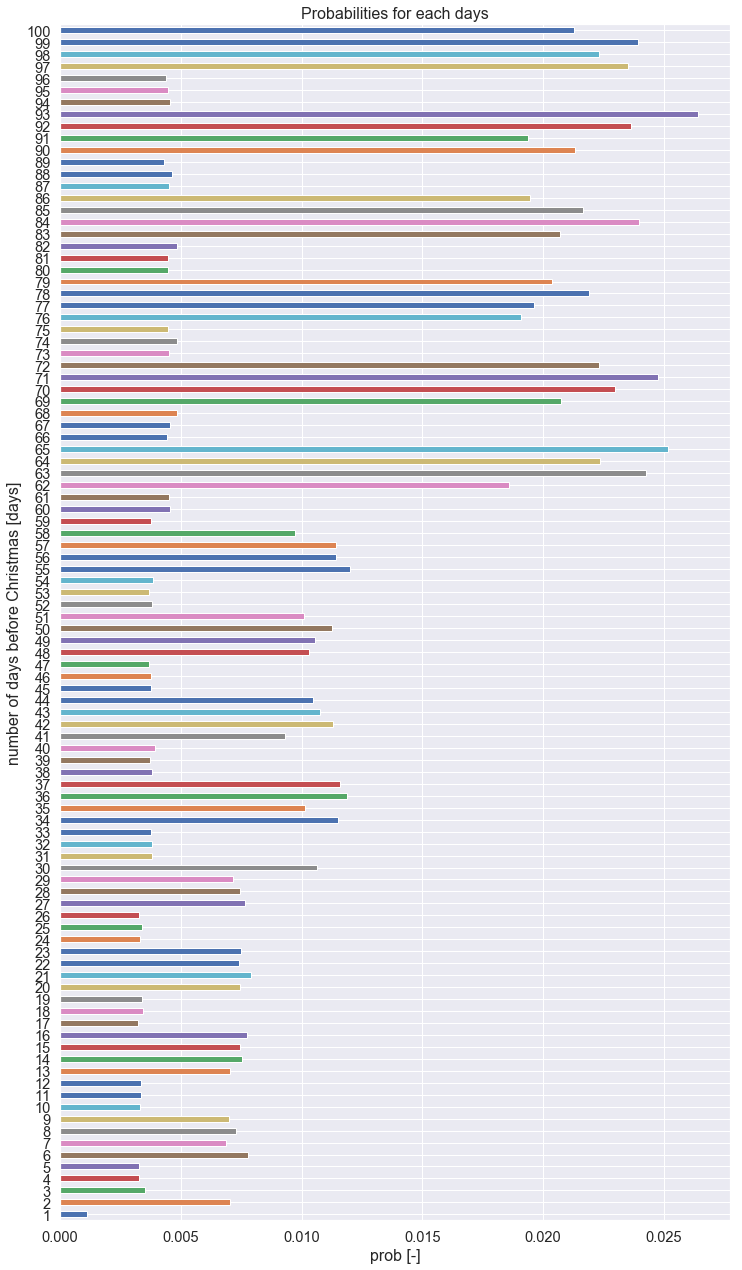

In [78]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [79]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

### Evolution of cost by number of people into family

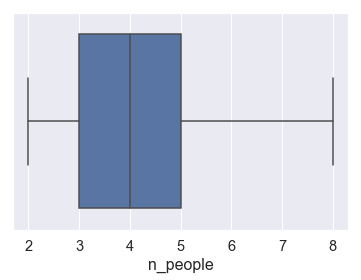

In [80]:
ax = sns.boxplot(x=data["n_people"])


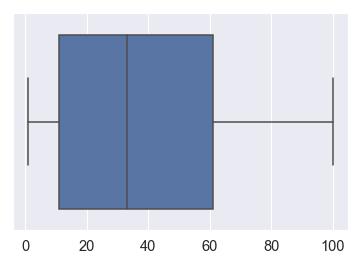

In [81]:
ax = sns.boxplot(data)

In [82]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [83]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


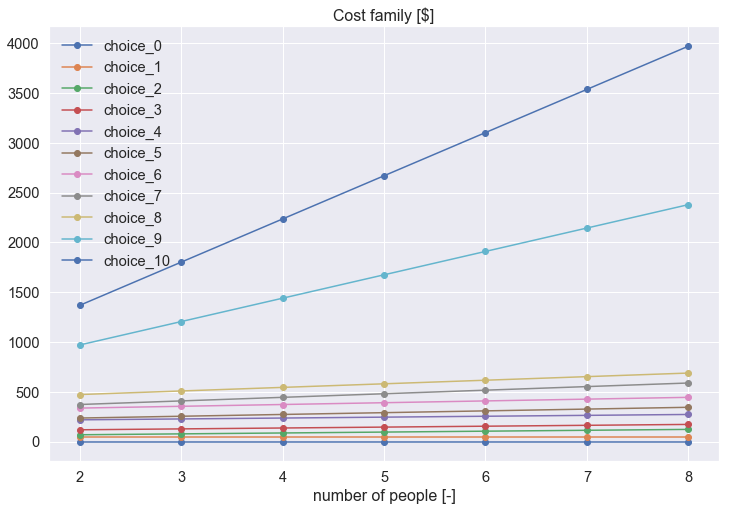

In [84]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

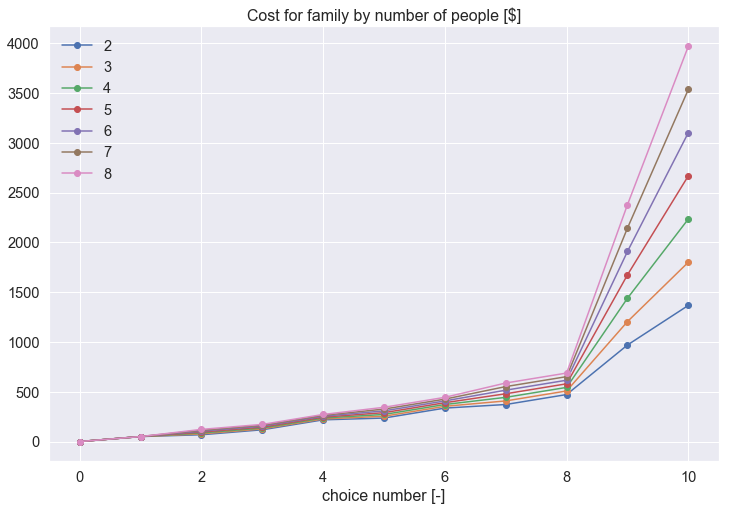

In [85]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [86]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 
                                                        CHOICE_RANGE_MAX + 1)]
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()
    return df_prob  



#### p max = 0.1, p min = 0.03

In [87]:
#df_prob = create_df_fam_cost_prob(df_fam_cost)
#df_prob

#### p max = 1, p min = 0.01

In [88]:
df_prob = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.100491,0.099238,0.098787,0.097535,0.095030,0.094580,0.092075,0.091173,0.088669,0.076195,0.066227
3,0.102556,0.101278,0.100588,0.099310,0.096753,0.096063,0.093507,0.092127,0.089571,0.071754,0.056494
4,0.104708,0.103403,0.102463,0.101158,0.098549,0.097609,0.094999,0.093120,0.090511,0.067127,0.046353
5,0.106952,0.105619,0.104419,0.103087,0.100421,0.099221,0.096556,0.094156,0.091491,0.062301,0.035777
6,0.109294,0.107932,0.106461,0.105099,0.102375,0.100904,0.098180,0.095238,0.092514,0.057264,0.024738
7,0.111742,0.110349,0.108594,0.107202,0.104417,0.102662,0.099877,0.096368,0.093583,0.052001,0.013205
8,0.114301,0.112877,0.110825,0.109401,0.106552,0.104501,0.101652,0.097550,0.094701,0.046497,0.001143


In [89]:
# save
joblib.dump(df_prob, PATH_TO_SAVE_DATA + '/df_prob.pkl')

['../../data/df_prob.pkl']

## Creation of days probabilities by family

In [90]:
df_prob_fam = create_df_prob_day_fam_optim(df_prob_day, df_prob)

In [91]:
df_prob_fam.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
family_id,,,,,,,,,,,,,,,,,,,,,
0,0.000562,0.003601,0.001803,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.048027,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
1,0.000562,0.003601,0.001803,0.054608,0.053444,0.051658,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
2,0.000565,0.003620,0.001813,0.001689,0.001673,0.004014,0.003534,0.003757,0.003596,0.049819,...,0.009982,0.012175,0.013593,0.002333,0.002306,0.002246,0.012107,0.011490,0.012313,0.063720
3,0.051653,0.055604,0.001822,0.001697,0.001682,0.052943,0.003552,0.003776,0.049467,0.001715,...,0.010032,0.012236,0.013661,0.002345,0.053636,0.052695,0.012168,0.011548,0.012375,0.011007
4,0.053490,0.003601,0.051766,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.065301,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895


In [92]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data/df_prob_fam.pkl']

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [13]:
submission = pd.read_csv(fpath, index_col='family_id')
#submission = pd.read_csv("submission_85403.67231932358_OK.csv", index_col='family_id')

In [14]:
submission.shape[0]

5000

In [15]:
df_range = create_seek_ranges(nb_first_seed=NB_FIRST_SEED)
df_range

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


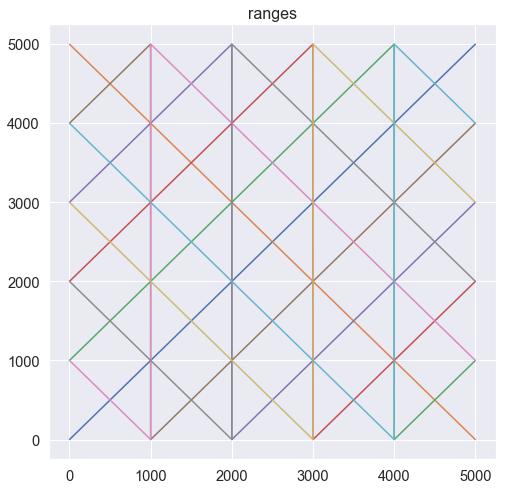

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [247]:
# Create baselines

# optimized version
t_fit_0 = time.time()
# Start with the sample submission values
submission = pd.read_csv(fpath, index_col='family_id')
best = submission['assigned_day'].values
start_cost = cost_function_optim(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            #day = choice_dict[f'choice_{pick}'][fam_id]
            day = arr_choice[fam_id, pick]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function_optim(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)
    submission['assigned_day'] = new
    score = cost_function_optim(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

Start cost:  10641498.403135022
Score: 672254.0276683343
Score: 627484.8599699548
Score: 587514.8278465485
Score: 569290.6931284127
Score: 548070.4010206381
Score: 543886.1774036238
Score: 542416.1088397022
Score: 541522.3543918737
Score: 536024.9660658052
Score: 535295.5188186927
Timing:  18.13469386100769


In [258]:
i_seed = 0
df_indiv = pd.read_csv(f'submission_range{i_seed}.csv', index_col='family_id')

for i_seed in range(1,10): 
    df_indiv_curr = pd.read_csv(f'submission_range{i_seed}.csv')
    df_indiv["assigned_day_{}".format(i_seed)] = df_indiv_curr["assigned_day"]
#seed_indiv[i_seed] = seed_indiv

In [259]:
df_indiv = df_indiv.T
df_indiv

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
assigned_day,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
assigned_day_1,52,26,100,2,53,32,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
assigned_day_2,52,26,100,2,53,32,88,25,18,1,...,61,29,90,62,52,16,20,32,67,13
assigned_day_3,52,26,100,2,53,32,88,25,18,1,...,61,45,12,62,52,16,88,32,67,13
assigned_day_4,52,26,100,2,53,32,88,25,18,1,...,61,47,12,62,52,16,88,32,67,13
assigned_day_5,52,26,100,2,53,32,88,25,18,1,...,61,47,12,62,52,16,88,32,67,13
assigned_day_6,52,26,100,2,53,32,88,25,18,1,...,61,47,12,62,52,16,88,32,67,13
assigned_day_7,52,26,100,2,53,32,88,25,18,1,...,61,45,12,62,52,16,88,32,67,13
assigned_day_8,52,26,100,2,53,32,88,25,18,1,...,61,45,12,62,52,16,88,32,67,13
assigned_day_9,52,26,100,2,53,32,88,25,18,1,...,61,45,12,62,52,16,88,32,67,13


In [260]:
df_indiv.describe()

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,10.0,10.0,10.0,10.0,10.0,10.00000,10.0,10.0,10.0,10.0,...,10.0,10.000000,10.00000,10.0,10.0,10.0,10.000000,10.0,10.0,10.0
mean,52.0,26.0,100.0,2.0,53.0,34.70000,88.0,25.0,18.0,1.0,...,61.0,40.800000,35.40000,62.0,52.0,16.0,81.200000,32.0,67.0,13.0
std,0.0,0.0,0.0,0.0,0.0,8.53815,0.0,0.0,0.0,0.0,...,0.0,8.189424,37.67758,0.0,0.0,0.0,21.503488,0.0,0.0,0.0
min,52.0,26.0,100.0,2.0,53.0,32.00000,88.0,25.0,18.0,1.0,...,61.0,29.000000,12.00000,62.0,52.0,16.0,20.000000,32.0,67.0,13.0
25%,52.0,26.0,100.0,2.0,53.0,32.00000,88.0,25.0,18.0,1.0,...,61.0,33.000000,12.00000,62.0,52.0,16.0,88.000000,32.0,67.0,13.0
50%,52.0,26.0,100.0,2.0,53.0,32.00000,88.0,25.0,18.0,1.0,...,61.0,45.000000,12.00000,62.0,52.0,16.0,88.000000,32.0,67.0,13.0
75%,52.0,26.0,100.0,2.0,53.0,32.00000,88.0,25.0,18.0,1.0,...,61.0,46.500000,70.50000,62.0,52.0,16.0,88.000000,32.0,67.0,13.0
max,52.0,26.0,100.0,2.0,53.0,59.00000,88.0,25.0,18.0,1.0,...,61.0,47.000000,90.00000,62.0,52.0,16.0,88.000000,32.0,67.0,13.0


In [261]:
pop_choices_info(df_indiv);

Mean Standard deviation over families for whole population :  0.16519330118524064
Info about std:  count    5000.000000
mean        0.165193
std         0.459490
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.270463
Name: std, dtype: float64


### Generate first population

#### Load

In [26]:
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

#### 10 ranges method

In [256]:
if SAVE_POP == '10R':
    
    # Create baselines
    # optimized version
    t_fit_0 = time.time()
    # Start with the sample submission values
    submission = pd.read_csv(fpath, index_col='family_id')
    best = submission['assigned_day'].values
    arr_range = df_range.values
    arr_sub, arr_score = boost_diff_browsing_optim(best, arr_range=arr_range)
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    _, df_des_choices_0, _ = pop_choices_info(pd.DataFrame(arr_sub))
    df_des_choices_0

Start cost:  10641498.403135022
Score:  672254.0276683343
Score:  627484.8599699548
Score:  587514.8278465485
Score:  569290.6931284127
Score:  548070.4010206381
Score:  543886.1774036238
Score:  542416.1088397022
Score:  541522.3543918737
Score:  536024.9660658052
Score:  535295.5188186927
Timing:  10.99387812614441


In [311]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None, 
                         delta_choice=DELTA_CHOICE_FIRST_POP):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    
    external argument : data & 
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    #if seed_indiv is None:
    #    seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    #df_pop = pd.DataFrame(index=range(0, nb_pop), 
    #                      columns=seed_indiv["family_id"])
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=range(seed_indiv.shape[0]))
    #print("df_pop.shape ", df_pop.shape)
    #for fam_id in seed_indiv["family_id"]:
    for fam_id in range(seed_indiv.shape[0]):
        #df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']
        df_pop[fam_id] = seed_indiv[fam_id]

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        #day_curr = seed_indiv.at[fam_id, 'assigned_day']
        day_curr = seed_indiv[fam_id]
        vect_pop_mutated = mutation_day_optim(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True, 
                                        delta_choice=delta_choice)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))
        #range_mut = rand_choice_nb(range(0, nb_pop), size=int(r_mut*nb_pop))
        #print("df_pop.shape: ", df_pop.shape)
        #print("range_mut.shape: ", range_mut.shape)
        #print("fam_id ", fam_id)
        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    #df_pop.loc[0] = seed_indiv['assigned_day']
    df_pop.loc[0] = seed_indiv
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [358]:
@njit
def generate_pop_choices_optim(seed_indiv=None, 
                               nb_pop=NB_FIRST_POP, 
                               r_mut=R_FIRST_MUT, 
                               delta_choice=DELTA_CHOICE_FIRST_POP):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return array population
    '''
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    print("delta choice: ", delta_choice)
    # initialize with same previous best indiv.
    arr_pop = np.zeros((nb_pop, seed_indiv.shape[0]), dtype=np.int64)
    
    for fam_id in range(seed_indiv.shape[0]):
        arr_pop[:, fam_id] = seed_indiv[fam_id]
        
    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in range(seed_indiv.shape[0]): # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv[fam_id]
        vect_pop_mutated = mutation_day_optim(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True, 
                                        delta_choice=delta_choice)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(np.arange(nb_pop), 
                                     size=int(r_mut*nb_pop))
        arr_pop[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    arr_pop[0] = seed_indiv
    
    print("Generation population is done.")
    
    return arr_pop

In [359]:
# OPTIM VERSION 
# std pop choices : 0.578

if SAVE_POP == '10R':
    t_tot_0 = time.time()
    nb_indiv_done = 0
    nb_range = df_range.index.shape[0]
    nb_indiv_range = np.floor(NB_FIRST_POP/df_range.shape[0])
    for i_seed in df_range.index:
        # choose number of indiv.
        nb_indiv_done += nb_indiv_range
        if i_seed == nb_range-1:
            if NB_FIRST_POP % nb_range != 0:
                nb_indiv_curr += NB_FIRST_POP % nb_range
        nb_indiv_curr = int(nb_indiv_curr)
        print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                           nb_indiv_done))
        # load best indiv in range #i_seed
        #seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
        seed_indiv = arr_sub[i_seed]
        #print("seed_indiv.shape: ", seed_indiv.shape)
        # generate sub-pop 
        t_fit_0 = time.time()
        arr_pop_curr = generate_pop_choices_optim(seed_indiv=seed_indiv, 
                                           nb_pop=nb_indiv_curr, 
                                           r_mut=R_FIRST_MUT, 
                                           delta_choice=DELTA_CHOICE_FIRST_POP)
        t_fit_1 = time.time()
        print("Timing : ", t_fit_1 - t_fit_0)
        df_pop_curr = pd.DataFrame(arr_pop_curr)
        
        # add sub-pop to pop
        if i_seed == 0:
            df_pop = df_pop_curr
        else:
            df_pop = df_pop.append(df_pop_curr, ignore_index=True)
            
    t_tot_1 = time.time()
    print("Timing TOTAL: ", t_tot_1 - t_tot_0)
    print("df_pop.shape: ", df_pop.shape) 
    df_choices_0, df_des_choices_0, std_mean_0 = pop_choices_info(df_pop)
    df_des_choices_0

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  1.1645619869232178
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  0.1507718563079834
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  0.17693281173706055
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  0.17218685150146484
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  0.15770912170410156
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.05
delta choice:  2
Generation population is done.
Timing :  0.176853895187

In [355]:
df_des_choices_0

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.085000,0.097000,0.093000,0.106000,0.087000,0.191000,0.098000,0.081000,0.110000,0.098000,...,1.057000,0.936000,0.958000,0.084000,0.095000,0.104000,0.285000,0.106000,0.108000,0.085000
std,0.491952,0.543955,0.498598,0.561319,0.521251,0.587251,0.539154,0.452376,0.579859,0.539154,...,0.407329,0.890335,1.394339,0.482884,0.536902,0.567015,0.759178,0.578877,0.566266,0.466897
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [352]:
df_pop.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,32,53,59,88,25,18,1,...,74,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,1,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


#### Save pop

In [30]:
if SAVE_POP == "10R": 
    #plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])
    
    
    path_df_pop_saved = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_fs{}_rfm{}_dc{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    NB_FIRST_SEED, 
                    R_FIRST_MUT, 
                    DELTA_CHOICE_FIRST_POP)
    # check file already exist : 
    if os.path.isfile(path_df_pop_saved):
        path_df_pop_saved_old = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_fs{}_rfm{}_dc{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    NB_FIRST_SEED, 
                    R_FIRST_MUT, 
                    DELTA_CHOICE_FIRST_POP,
                    datetime.today().strftime ('%Y_%m_%d_%H_%M_%S'))
        os.rename(path_df_pop_saved, path_df_pop_saved_old)
    # save
    joblib.dump(df_pop, path_df_pop_saved, compress=True)

['../../data/df_pop_choices1000_fs10_rfm0.05_dc1.pkl']

### Eval with new crossing prob

#### Load

##### Ranges to seek for boost mode

In [117]:
try:
    df_range
except:
    df_range = create_seek_ranges(nb_first_seed=NB_FIRST_SEED)

arr_range = df_range.values # f(num range, families)
df_range



,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


##### Load Pre-generate population

Loading:  ../../data/df_pop_choices_10R_1000_fs10_rfm0.05_dc2.pkl
Infos about population: 
Max Same indiv nb :  0
Mean Standard deviation over families for whole population :  0.5780457784564
Info about std:  count    5000.000000
mean        0.578046
std         0.342170
min         0.251122
25%         0.489913
50%         0.532048
75%         0.581747
max         4.924657
Name: std, dtype: float64


family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.089000,0.089000,0.091000,0.080000,0.090000,0.176000,0.110000,0.11300,0.079000,0.106000,...,1.047000,0.948000,0.974000,0.085000,0.096000,0.100000,0.284000,0.099000,0.089000,0.095000
std,0.507283,0.507283,0.510862,0.442488,0.481801,0.568636,0.581583,0.59715,0.459315,0.552331,...,0.385927,0.889993,1.418216,0.489913,0.497022,0.523712,0.756251,0.536178,0.517055,0.521773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


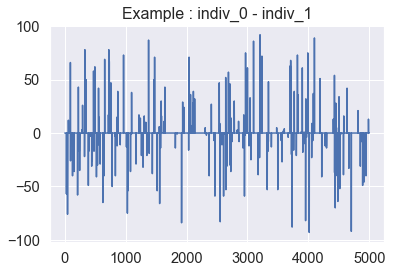

In [118]:
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))


if (SAVE_POP is None) & os.path.isfile(PATH_DF_POP):
    print("Loading: ", PATH_DF_POP)
    df_pop = joblib.load(PATH_DF_POP)
else:
    print("Loading: ", path_df_pop_saved)
    df_pop = joblib.load(path_df_pop_saved)
    
# info about first pop
print("Infos about population: ")
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])
plt.title("Example : indiv_0 - indiv_1")
print("Max Same indiv nb : ", find_max_same_indiv(df_pop.values))
_, df_des_choices_0, _ = pop_choices_info(df_pop)
df_des_choices_0

#### Initialize costs

Timing:  0.16379213333129883


,cost
900,535295.518819
800,536024.966066
700,541522.354392
600,542416.108840
500,543886.177404
400,548070.401021
300,569290.693128
200,587514.827847
100,627484.859970
0,672254.027668


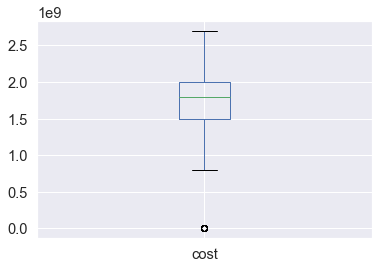

In [119]:
# create cost dataFrame for all population
'''t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print("Timing: ", time.time()-t_1)

df_cost.boxplot()

df_cost.sort_values(by="cost").head(10)'''



t_0 = time.time()
arr_pop = np.array(df_pop)
arr_score = eval_cost_vect_optim(arr_pop)
df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
print("Timing: ", time.time()-t_0)
df_cost.boxplot()
df_cost.sort_values(by="cost").head(10)


#### Selection probability

In [120]:
POW_SELECTION = 0.3

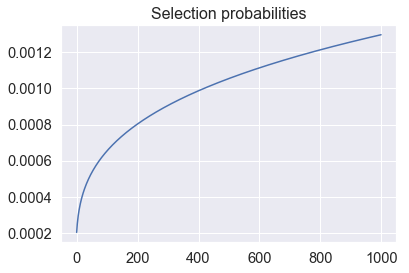

In [121]:
# Prob for indiv = inverse rank * POW_SELECTION
arr_select_prob = selection_prob(df_cost, pow_selection=POW_SELECTION)
plt.plot(np.sort(arr_select_prob))
plt.title("Selection probabilities");

####  Loop over generations

In [122]:
## HYPERPARAMETERS

# TEST NEW PARAM
NB_MAX_EPOCHS = 50000
R_POP_MUT = 0.1
R_MUT = 0.01 
DELTA_CHOICE = 2
NB_BEST_KEEP = 20 
POW_SELECTION = 0.3
flag_boost = True
boost_freq = 2000
R_CROSSOVER = 1

'''# TEST OLD PARAMS
NB_MAX_EPOCHS = 10000
R_POP_MUT = 0.1 # % population mutated at each gen. default : 0.10
R_MUT = 0.01 # % families mutated at each gen default : 0.01
DELTA_CHOICE = 2 # default : 2
NB_BEST_KEEP = 20 # NEW PARAM : how much best one to keep
POW_SELECTION = 0.3 # default 0.3
flag_boost = True
boost_freq = 2000'''

## DISPLAY PARAM
flag_prompt = True # timing information to each steps 
prompt_freq = 100 #100 # frequency info about cost & timing 

## Other param
FIRST_COST = df_cost.sort_values(by="cost")["cost"].iloc[0]
FIRST_COST

## PREPARE LOOP
# prepare data 
nb_indiv_boost = 0
list_best_cost = []
t_fit_0 = time.time()

## LOOP OVER GENERATIONS 
for gen_id in range(0, NB_MAX_EPOCHS):
    
    t_epoch_0 = time.time()
    if flag_prompt:
        t_lost_0 = time.time()

    # keep 1st current best score 
    list_best_cost.append(df_cost.sort_values(by="cost").iloc[0]["cost"])
    

    '''df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["inv_rank"] = range(df_cost.shape[0]+1, 1, -1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    for indice in range(0, NB_BEST_KEEP):
        list_name_best.append(df_cost_sort.iloc[indice].name)
    
    df_best = df_pop.loc[list_name_best]
    df_cost_best = df_cost.loc[list_name_best]'''
    
    '''    
    # AVOID DUPLICATE INDIV
    df_best["cost"] = df_cost_best["cost"]
    df_best.drop_duplicates(subset=["cost"], inplace=True)
    df_best.drop(columns=["cost"], inplace=True)
    df_cost_best.drop_duplicates(subset=["cost"], inplace=True)
    '''

    ############
    # SELECTION  
    # calculation of probabilities for crossing next generation 
    # prob =  (1/rank)^POW_SELECTION

    # Keep the NB_BEST_KEEP best indiv.s
    arr_select_prob, df_best, df_cost_best = selection_prob(df_cost, 
      pow_selection=POW_SELECTION, df_pop=df_pop, flag_ouput=True,
      nb_best_keep=NB_BEST_KEEP)
    
    #arr_select_prob = selection_prob(df_cost, POW_SELECTION)
    #arr_select_prob = np.zeros(df_pop.shape[0])
    #arr_select_prob[df_cost_sort.index] = df_cost_sort["inv_rank"].values
    #arr_select_prob = (arr_select_prob)**POW_SELECTION 
    #arr_select_prob = arr_select_prob / np.sum(arr_select_prob)
    
    if flag_prompt:
        t_lost_1 = time.time()
        print("Timing lost: ", t_lost_1 - t_lost_0)
        
    ############
    # CROSSOVER 
    #
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    if flag_prompt:
        t_cross_0 = time.time()
        
    arr_pop = np.array(df_pop) # df_pop = f(indiv., families)

    # crossing with more prob for best indiv.
    # number of new children = N pop - N best to keep same nb of indiv each gen.
    nb_cross = int(NB_FIRST_POP - NB_BEST_KEEP - nb_indiv_boost)
    # reset nb boost indiv
    if nb_indiv_boost > 0:
        nb_indiv_boost = 0 

    arr_pop = generate_crossing_prob(arr_pop.copy(), p=arr_select_prob, 
                                     n_indiv=nb_cross, r_cross=R_CROSSOVER)
    #print("Max Same indiv nb after crossing : ", find_max_same_indiv(arr_pop))
    if flag_prompt:
        t_cross_1 = time.time()
        print("Timing cross: ", t_cross_1 - t_cross_0)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # arr_pop or df_pop = f(indiv, family)
    if flag_prompt:
        t_mut_0 = time.time()
    arr_pop = fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, 
                delta_choice=DELTA_CHOICE)
    #print("Max Same indiv nb after mutation : ", find_max_same_indiv(arr_pop))
    
    ############    
    ## ADD the best ones
    #
    arr_pop = np.append(arr_pop, np.array(df_best), axis=0)
    # AVOID DUPLICATE INDIV 
    #arr_pop = np.unique(arr_pop, axis=0)  # replace by cost because too slow
    df_pop = pd.DataFrame(data=arr_pop)
    #print("Max Same indiv nb after add best : ", find_max_same_indiv(arr_pop))
    if flag_prompt:
        t_mut_1 = time.time()
        print("Timing mutation: ", t_mut_1 - t_mut_0)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    if flag_prompt:
        t_eval_0 = time.time()
    '''df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(arr_pop[indice,:])'''
    # optim
    arr_score = eval_cost_vect_optim(arr_pop)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    
    ##########
    # BOOSTING
    #
    # cost of last best submission

    if flag_boost & (gen_id % boost_freq == 0) & (gen_id > 0) :
        best = df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].values
    
        '''arr_sub, arr_score = boost_diff_browsing(arr_choice=arr_choice, 
                                             best=best, arr_range=arr_range)'''
        arr_sub, arr_score = boost_diff_browsing_optim(best=best, 
                                                       arr_range=arr_range)
    
        df_new_indiv = pd.DataFrame(data=arr_sub, columns=df_pop.columns)
        nb_indiv_boost = df_new_indiv.shape[0]
        df_pop = df_pop.append(df_new_indiv, ignore_index=True)
    
        df_score = pd.DataFrame(data=arr_score, columns=['cost'])
        df_cost = df_cost.append(df_score, ignore_index=True)
    
    ##########
    # AVOID DUPLICATES BY SAME COST : very FASTER
    # but potential diff indiv elimitated...
    #
    df_cost.drop_duplicates(subset=["cost"], inplace=True)
    df_pop = df_pop.filter(items=df_cost.index, axis=0)
    df_cost.reset_index(drop=True, inplace=True)
    df_pop.reset_index(drop=True, inplace=True)

    if flag_prompt:
        t_eval_1 = time.time()
        print("Timing eval: ", t_eval_1 - t_eval_0)
    
    ##########
    # DISPLAY
    #
    t_epoch_1 = time.time()
    if (flag_prompt) | (gen_id % prompt_freq == 0):
        print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))
        #print("Max Same indiv nb : ", find_max_same_indiv(arr_pop))

# timing 
t_fit_1 = time.time()
print("END:")
print("LAST GEN. #{} / cost: {} / nb. pop: {} / timing Total: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_fit_1 - t_fit_0)) 
# figure
fig = plt.figure(figsize=(12, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

Timing lost:  0.007464885711669922
Timing cross:  0.16321086883544922
Timing mutation:  0.060984134674072266
Timing eval:  0.07990503311157227
GEN. #0 / cost: [535295.51881869] / nb. pop: 1000 / timing: 0.3126239776611328
Timing lost:  0.010440826416015625
Timing cross:  0.07496809959411621
Timing mutation:  0.06960296630859375
Timing eval:  0.07605886459350586
GEN. #1 / cost: [535295.51881869] / nb. pop: 1000 / timing: 0.23241806030273438
Timing lost:  0.0033659934997558594
Timing cross:  0.11413192749023438
Timing mutation:  0.1023099422454834
Timing eval:  0.042343854904174805
GEN. #2 / cost: [535295.51881869] / nb. pop: 1000 / timing: 0.2629408836364746
Timing lost:  0.011167049407958984
Timing cross:  0.07257604598999023
Timing mutation:  0.0452420711517334
Timing eval:  0.03481793403625488
GEN. #3 / cost: [535295.51881869] / nb. pop: 1000 / timing: 0.16530895233154297
Timing lost:  0.003243684768676758
Timing cross:  0.11137199401855469
Timing mutation:  0.04834175109863281
Timin

Timing eval:  0.028162002563476562
GEN. #37 / cost: [535295.51881869] / nb. pop: 997 / timing: 0.15341782569885254
Timing lost:  0.0037250518798828125
Timing cross:  0.07033801078796387
Timing mutation:  0.044245004653930664
Timing eval:  0.02438664436340332
GEN. #38 / cost: [535295.51881869] / nb. pop: 999 / timing: 0.14388203620910645
Timing lost:  0.0033180713653564453
Timing cross:  0.04119396209716797
Timing mutation:  0.08291792869567871
Timing eval:  0.03119826316833496
GEN. #39 / cost: [535295.51881869] / nb. pop: 998 / timing: 0.16541099548339844
Timing lost:  0.0040361881256103516
Timing cross:  0.05030417442321777
Timing mutation:  0.06583309173583984
Timing eval:  0.038301944732666016
GEN. #40 / cost: [535295.51881869] / nb. pop: 997 / timing: 0.1590430736541748
Timing lost:  0.005142927169799805
Timing cross:  0.0766441822052002
Timing mutation:  0.05112504959106445
Timing eval:  0.058923959732055664
GEN. #41 / cost: [535295.51881869] / nb. pop: 1000 / timing: 0.1940608024

Timing eval:  0.032507896423339844
GEN. #75 / cost: [535295.51881869] / nb. pop: 997 / timing: 0.12256479263305664
Timing lost:  0.021622896194458008
Timing cross:  0.05173087120056152
Timing mutation:  0.05083584785461426
Timing eval:  0.03687405586242676
GEN. #76 / cost: [535295.51881869] / nb. pop: 994 / timing: 0.1621570587158203
Timing lost:  0.0033409595489501953
Timing cross:  0.039489030838012695
Timing mutation:  0.06344103813171387
Timing eval:  0.023806333541870117
GEN. #77 / cost: [535295.51881869] / nb. pop: 999 / timing: 0.13152694702148438
Timing lost:  0.0047206878662109375
Timing cross:  0.03944277763366699
Timing mutation:  0.037101030349731445
Timing eval:  0.023555994033813477
GEN. #78 / cost: [535295.51881869] / nb. pop: 994 / timing: 0.1061859130859375
Timing lost:  0.0038263797760009766
Timing cross:  0.08385300636291504
Timing mutation:  0.04384493827819824
Timing eval:  0.031478166580200195
GEN. #79 / cost: [535295.51881869] / nb. pop: 994 / timing: 0.164113283

Timing eval:  0.0348200798034668
GEN. #113 / cost: [535286.8901144] / nb. pop: 991 / timing: 0.13384604454040527
Timing lost:  0.020406007766723633
Timing cross:  0.048139095306396484
Timing mutation:  0.04096221923828125
Timing eval:  0.03274083137512207
GEN. #114 / cost: [535286.8901144] / nb. pop: 995 / timing: 0.14399003982543945
Timing lost:  0.004090070724487305
Timing cross:  0.04980015754699707
Timing mutation:  0.08878684043884277
Timing eval:  0.026472806930541992
GEN. #115 / cost: [535286.8901144] / nb. pop: 983 / timing: 0.17147111892700195
Timing lost:  0.0027170181274414062
Timing cross:  0.04950118064880371
Timing mutation:  0.11167407035827637
Timing eval:  0.06952810287475586
GEN. #116 / cost: [535286.8901144] / nb. pop: 990 / timing: 0.23394775390625
Timing lost:  0.004572153091430664
Timing cross:  0.08424115180969238
Timing mutation:  0.05576491355895996
Timing eval:  0.03535890579223633
GEN. #117 / cost: [535286.8901144] / nb. pop: 986 / timing: 0.1882312297821045


Timing eval:  0.034175872802734375
GEN. #150 / cost: [533902.40258091] / nb. pop: 989 / timing: 0.1406080722808838
Timing lost:  0.014250993728637695
Timing cross:  0.06376910209655762
Timing mutation:  0.04236268997192383
Timing eval:  0.025199174880981445
GEN. #151 / cost: [533902.40258091] / nb. pop: 995 / timing: 0.1461319923400879
Timing lost:  0.0037631988525390625
Timing cross:  0.03774690628051758
Timing mutation:  0.06117725372314453
Timing eval:  0.028359174728393555
GEN. #152 / cost: [533902.40258091] / nb. pop: 993 / timing: 0.13234186172485352
Timing lost:  0.0027382373809814453
Timing cross:  0.055838823318481445
Timing mutation:  0.041007041931152344
Timing eval:  0.026289939880371094
GEN. #153 / cost: [533902.40258091] / nb. pop: 988 / timing: 0.12688112258911133
Timing lost:  0.0036039352416992188
Timing cross:  0.042809247970581055
Timing mutation:  0.10642194747924805
Timing eval:  0.029691219329833984
GEN. #154 / cost: [533902.40258091] / nb. pop: 987 / timing: 0.18

Timing cross:  0.047759056091308594
Timing mutation:  0.045957088470458984
Timing eval:  0.025339126586914062
GEN. #188 / cost: [532033.01440362] / nb. pop: 993 / timing: 0.12686491012573242
Timing lost:  0.006154060363769531
Timing cross:  0.06435489654541016
Timing mutation:  0.03824281692504883
Timing eval:  0.03228306770324707
GEN. #189 / cost: [532033.01440362] / nb. pop: 990 / timing: 0.14255213737487793
Timing lost:  0.003537893295288086
Timing cross:  0.06301307678222656
Timing mutation:  0.0413508415222168
Timing eval:  0.025654077529907227
GEN. #190 / cost: [532033.01440362] / nb. pop: 991 / timing: 0.13457822799682617
Timing lost:  0.004060983657836914
Timing cross:  0.0532839298248291
Timing mutation:  0.058075904846191406
Timing eval:  0.032518863677978516
GEN. #191 / cost: [532007.03346127] / nb. pop: 993 / timing: 0.1488490104675293
Timing lost:  0.0026769638061523438
Timing cross:  0.04575777053833008
Timing mutation:  0.04164290428161621
Timing eval:  0.031906127929687

KeyboardInterrupt: 

In [58]:
#arr_select_prob
t_cross_0 = time.time()
arr_pop = generate_crossing_prob(arr_pop, p=arr_select_prob, 
                                 n_indiv=1000, r_cross=R_CROSSOVER)

t_cross_1 = time.time()
print("Timing cross: ", t_cross_1 - t_cross_0)

Timing cross:  0.027293920516967773


In [67]:
%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)

27 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
R_CROSSOVER

1

In [62]:
'''%timeit np.unique(arr_pop, axis=0)'''

'%timeit np.unique(arr_pop, axis=0)'

In [63]:
'''@njit
def test_unique(arr_pop):
    return np.unique(arr_pop, axis=0)

%time test_unique(arr_pop)'''

'@njit\ndef test_unique(arr_pop):\n    return np.unique(arr_pop, axis=0)\n\n%time test_unique(arr_pop)'

In [136]:
find_max_same_indiv(df_pop)

0

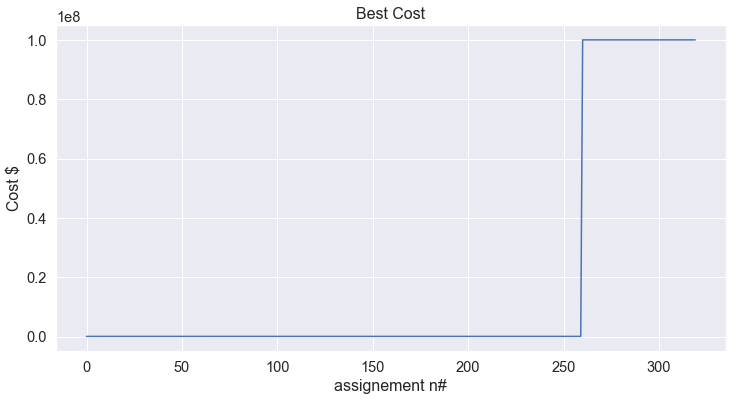

In [137]:
fig = plt.figure(figsize=(12, 6))
plt.plot(df_cost.sort_values(by="cost").head(NB_BEST_KEEP+300).values)
ax = fig.gca()
ax.set_title("Best Cost")
ax.set_ylabel("Cost $")
ax.set_xlabel('assignement n#');

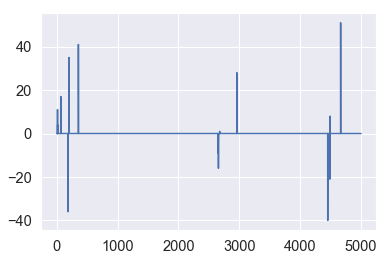

In [138]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [139]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[102186.25266789]


#### Save results

In [140]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)

# submission csv
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]
submission_final.index.name = 'family_id'
submission_final.to_csv("submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))           
print("Submission saved here :", "submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))

# SUBMISSION pickle
joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)
# list cost vs epochs 
joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)




Submission saved here : submission_102186.25266789172.csv


['../../data/list_best_cost1000_fs10_rfm0.05_dc2_rm0.1_nk_20_gen40000_s102186.25266789172.pkl']

In [141]:
#NB_FIRST_SEED = 10
#DELTA_CHOICE_FIRST_POP = 1
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
#NB_MAX_EPOCHS = 10000
#R_POP_MUT = 0.2 # % population mutated at each gen. default : 0.10
#R_MUT = 0.2 # % families mutated at each gen default : 0.01
#DELTA_CHOICE = 4 # default : 2
#NB_BEST_KEEP = 20 # NEW PARAM : how much best one to keep
#POW_SELECTION = 0.1 # default 0.3
#flag_boost = False
#boost_freq = 2000
#COMPUTERNAME
# FIRST_COST
BEST_COST = df_cost.sort_values(by="cost")["cost"].iloc[0]
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
try:
    timing = t_fit_1 - t_fit_0
except:
    timing = t_epoch_1 - t_fit_0 

nb_pop = df_pop.shape[0]
df_res = pd.DataFrame(columns=["date", "COMPUTERNAME", "FIRST_COST", 
                               "BEST_COST", "NB_MAX_EPOCHS", "timing", "nb_pop",
                              "NB_FIRST_SEED", "DELTA_CHOICE_FIRST_POP",
                              "R_FIRST_MUT", "R_POP_MUT", "R_MUT", 
                               "DELTA_CHOICE", "NB_BEST_KEEP", "POW_SELECTION",
                              "flag_boost", "boost_freq"], index=[0])

df_res["date"] = dt_string
df_res["COMPUTERNAME"] = COMPUTERNAME
df_res["FIRST_COST"] = FIRST_COST
df_res["BEST_COST"] = BEST_COST
df_res["NB_MAX_EPOCHS"] = NB_MAX_EPOCHS
df_res["timing"] = timing
df_res["nb_pop"] = df_pop.shape[0]
df_res["NB_FIRST_SEED"] = NB_FIRST_SEED
df_res["DELTA_CHOICE_FIRST_POP"] = DELTA_CHOICE_FIRST_POP
df_res["R_FIRST_MUT"] = R_FIRST_MUT
df_res["R_POP_MUT"] = R_POP_MUT
df_res["R_MUT"] = R_MUT
df_res["DELTA_CHOICE"] = DELTA_CHOICE
df_res["NB_BEST_KEEP"] = NB_BEST_KEEP
df_res["POW_SELECTION"] = POW_SELECTION
df_res["flag_boost"] = flag_boost
df_res["boost_freq"] = boost_freq
df_res.index.name = 'job'
df_res.to_csv(PATH_TO_SAVE_DATA + \
              '/res_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.csv'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]))
df_res

,date,COMPUTERNAME,FIRST_COST,BEST_COST,NB_MAX_EPOCHS,timing,nb_pop,NB_FIRST_SEED,DELTA_CHOICE_FIRST_POP,R_FIRST_MUT,R_POP_MUT,R_MUT,DELTA_CHOICE,NB_BEST_KEEP,POW_SELECTION,flag_boost,boost_freq
job,,,,,,,,,,,,,,,,,
0,02/02/2020 14:26:33,MacBook-Pro-de-Gregory.local,533411.213872,102186.252668,40000,5816.858867,979,10,2,0.05,0.1,0.01,2,20,0.3,True,2000


#### Explore res

In [142]:
'''df_pop = pd.read_csv(PATH_TO_SAVE_DATA + \
            '/df_pop1000_fs10_rfm0.01_dc3_rm0.2_nk_20_gen10000_s85181.csv',
                    index_col="Unnamed: 0")
df_pop.index = df_pop.index.astype(np.int64)
df_pop.columns = df_pop.columns.astype(np.int64)
df_cost = pd.read_csv(PATH_TO_SAVE_DATA + \
            '/df_cost_pop1000_fs10_rfm0.01_dc3_rm0.2_nk_20_gen10000_s85181.csv',
                     index_col="Unnamed: 0")'''


'df_pop = pd.read_csv(PATH_TO_SAVE_DATA +             \'/df_pop1000_fs10_rfm0.01_dc3_rm0.2_nk_20_gen10000_s85181.csv\',\n                    index_col="Unnamed: 0")\ndf_pop.index = df_pop.index.astype(np.int64)\ndf_pop.columns = df_pop.columns.astype(np.int64)\ndf_cost = pd.read_csv(PATH_TO_SAVE_DATA +             \'/df_cost_pop1000_fs10_rfm0.01_dc3_rm0.2_nk_20_gen10000_s85181.csv\',\n                     index_col="Unnamed: 0")'

In [143]:
df_choices, df_des_choices, std_mean = pop_choices_info(df_pop)
df_des_choices

Mean Standard deviation over families for whole population :  0.12204529621585083
Info about std:  count    5000.000000
mean        0.122045
std         0.106862
min         0.000000
25%         0.045175
50%         0.110600
75%         0.168895
max         1.064608
Name: std, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,979.000000,979.0,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,...,979.000000,979.0,979.000000,979.0,979.000000,979.0,979.000000,979.000000,979.0,979.000000
mean,0.138917,0.0,0.018386,0.007150,0.025536,0.002043,0.001021,0.132789,0.002043,0.003064,...,1.003064,0.0,0.002043,0.0,0.001021,0.0,0.014300,0.006129,1.0,0.003064
std,0.629138,0.0,0.259126,0.139199,0.240061,0.063920,0.031960,0.712679,0.063920,0.095880,...,0.095880,0.0,0.063920,0.0,0.031960,0.0,0.168598,0.135526,0.0,0.095880
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000
max,3.000000,0.0,4.000000,4.000000,4.000000,2.000000,1.000000,4.000000,2.000000,3.000000,...,4.000000,0.0,2.000000,0.0,1.000000,0.0,2.000000,4.000000,1.0,3.000000


In [371]:
df_pop_0 = joblib.load(
    PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE_FIRST_POP))

df_choices_0, df_des_choices_0, std_mean_0 = pop_choices_info(df_pop_0)
df_des_choices_0

Mean Standard deviation over families for whole population :  0.5780457784564
Info about std:  count    5000.000000
mean        0.578046
std         0.342170
min         0.251122
25%         0.489913
50%         0.532048
75%         0.581747
max         4.924657
Name: std, dtype: float64


family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.089000,0.089000,0.091000,0.080000,0.090000,0.176000,0.110000,0.11300,0.079000,0.106000,...,1.047000,0.948000,0.974000,0.085000,0.096000,0.100000,0.284000,0.099000,0.089000,0.095000
std,0.507283,0.507283,0.510862,0.442488,0.481801,0.568636,0.581583,0.59715,0.459315,0.552331,...,0.385927,0.889993,1.418216,0.489913,0.497022,0.523712,0.756251,0.536178,0.517055,0.521773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [372]:
filename = 'df_pop1000_fs10_rfm0.01_dc4_rm0.2_nk_20_gen20000_s88121.pkl'

df_pop_1 = joblib.load(PATH_TO_SAVE_DATA + '/' + filename)
df_choices_1, df_des_choices_1, std_mean_1 = pop_choices_info(df_pop_1)
df_des_choices_1

Mean Standard deviation over families for whole population :  0.12341939394907221
Info about std:  count    5000.000000
mean        0.123419
std         0.106092
min         0.000000
25%         0.045061
50%         0.110207
75%         0.170420
max         0.924377
Name: std, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,986.000000,986.000000,986.0,986.000000,986.000000,986.000000,986.000000,986.000000,986.0,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,0.001014,0.027383,0.0,0.009128,0.012170,0.043611,0.006085,0.027383,0.0,0.042596,...,0.998986,0.032454,0.003043,0.005071,0.011156,0.004057,0.006085,0.006085,1.003043,0.008114
std,0.031846,0.306048,0.0,0.165311,0.155619,0.396846,0.135045,0.285452,0.0,0.234599,...,0.031846,0.222951,0.095539,0.095453,0.145586,0.100677,0.142364,0.110207,0.105633,0.155883
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,4.000000,0.0,3.000000,3.000000,4.000000,3.000000,3.000000,0.0,4.000000,...,1.000000,4.000000,3.000000,2.000000,2.000000,3.000000,4.000000,2.000000,4.000000,4.000000


##### Best

In [373]:
best = df_pop.loc[df_cost["cost"].idxmin()].values

In [374]:
cost_function_optim(best)

279401.9134596732

In [375]:
cost_function(best)

279401.9134596732

In [376]:
penalty, accounting_cost , daily_occupancy = cost_function(best, flag_prompt=True)

penalty for only families:  274064
daily_occupancy:  {100: 127, 99: 125, 98: 125, 97: 128, 96: 175, 95: 210, 94: 233, 93: 125, 92: 126, 91: 128, 90: 158, 89: 200, 88: 232, 87: 254, 86: 125, 85: 125, 84: 126, 83: 140, 82: 183, 81: 215, 80: 231, 79: 125, 78: 125, 77: 125, 76: 125, 75: 171, 74: 195, 73: 204, 72: 126, 71: 126, 70: 125, 69: 131, 68: 175, 67: 212, 66: 242, 65: 125, 64: 126, 63: 125, 62: 156, 61: 196, 60: 230, 59: 247, 58: 222, 57: 125, 56: 157, 55: 183, 54: 216, 53: 239, 52: 246, 51: 213, 50: 177, 49: 198, 48: 221, 47: 248, 46: 264, 45: 239, 44: 204, 43: 187, 42: 166, 41: 198, 40: 230, 39: 241, 38: 219, 37: 182, 36: 162, 35: 195, 34: 221, 33: 254, 32: 275, 31: 273, 30: 243, 29: 241, 28: 251, 27: 267, 26: 288, 25: 299, 24: 285, 23: 259, 22: 238, 21: 228, 20: 250, 19: 277, 18: 296, 17: 296, 16: 275, 15: 257, 14: 264, 13: 278, 12: 299, 11: 299, 10: 291, 9: 267, 8: 244, 7: 235, 6: 254, 5: 281, 4: 300, 3: 300, 2: 284, 1: 299}
accounting_cost:  5337.913459673204


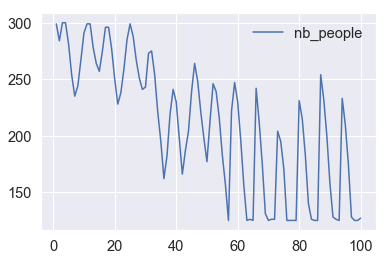

In [377]:
df_daily = pd.DataFrame(index=daily_occupancy.keys(), data=list(daily_occupancy.values()), 
             columns=['nb_people'])
#daily_occupancy.keys()
#daily_occupancy.values()
df_daily.plot()

In [378]:
df_daily.describe()

,nb_people
count,100.000000
mean,210.030000
std,58.328823
min,125.000000
25%,157.750000
50%,220.000000
75%,254.000000
max,300.000000


In [379]:
70000/5000

14.0

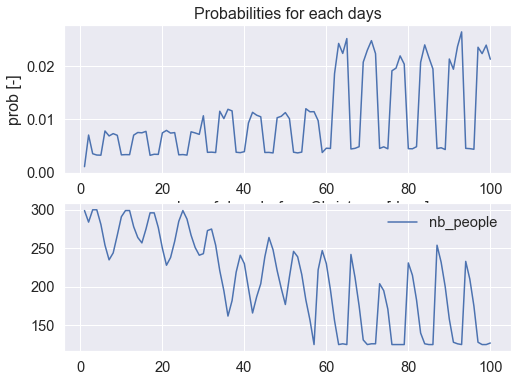

In [380]:
fig = plt.figure(figsize=(8, 6)) 
ax1 = fig.add_subplot(2,1,1)
df_prob_day["prob"].plot(ax=ax1)
ax1.set_ylabel("prob [-]")
ax1.set_xlabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");
ax2 = fig.add_subplot(2,1,2)
df_daily.plot(ax=ax2)

In [381]:
arr_choices = np.zeros(best.shape[0])*np.nan
for fam_id, day_curr in enumerate(best):
    arr_choices[fam_id] = find_choice_from_day_optim(day_curr, fam_id)

df_best = pd.DataFrame(arr_choices.astype(np.int64), columns=["choice"]) 
df_best["day"] = best
df_best.describe()

,choice,day
count,5000.000000,5000.000000
mean,0.431600,44.061000
std,1.357973,28.706154
min,0.000000,1.000000
25%,0.000000,19.000000
50%,0.000000,41.000000
75%,0.000000,67.000000
max,10.000000,100.000000


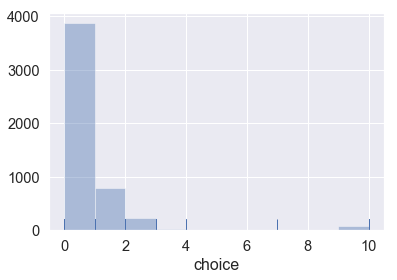

In [382]:
sns.distplot(df_best["choice"], bins=10, kde=False, rug=True)

In [383]:
df_best["choice"].value_counts()

0     3871
1      786
2      231
10      81
3       27
4        3
7        1
Name: choice, dtype: int64

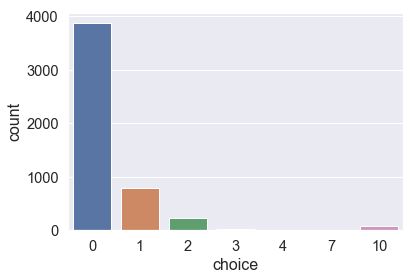

In [384]:
ax = sns.countplot(x="choice", data=df_best)

##### All population

In [385]:
df_des_choices

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,858.0,858.000000,858.0,858.000000,858.0,858.000000,858.0,858.0,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.0,858.0,858.000000,858.000000,858.000000,858.000000
mean,0.0,0.001166,0.0,0.002331,0.0,0.002331,0.0,0.0,0.001166,0.004662,...,0.001166,0.003497,0.002331,0.001166,0.0,0.0,0.004662,0.002331,0.998834,0.002331
std,0.0,0.034139,0.0,0.068279,0.0,0.068279,0.0,0.0,0.034139,0.096505,...,0.034139,0.076302,0.068279,0.034139,0.0,0.0,0.096505,0.048252,0.034139,0.068279
min,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000
50%,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000
75%,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000
max,0.0,1.000000,0.0,2.000000,0.0,2.000000,0.0,0.0,1.000000,2.000000,...,1.000000,2.000000,2.000000,1.000000,0.0,0.0,2.000000,1.000000,1.000000,2.000000


In [386]:
df_des_choices.loc["std"].max()

0.49616305965583923

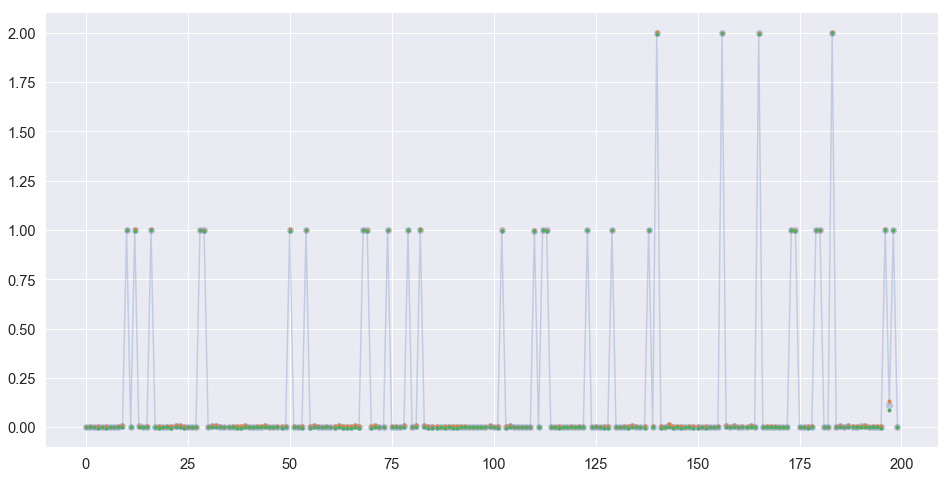

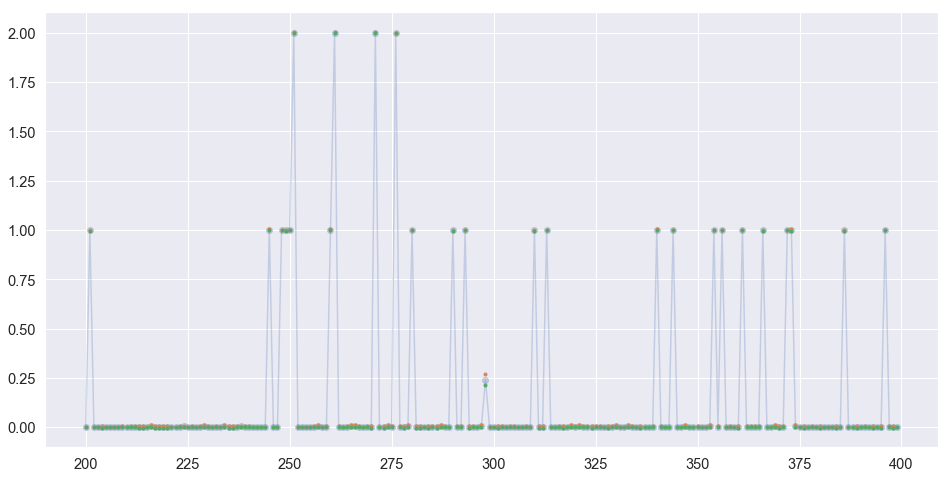

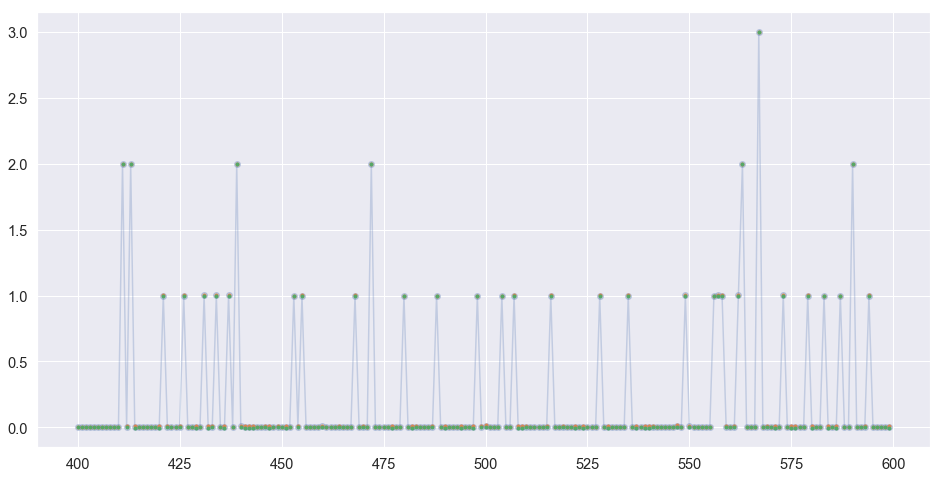

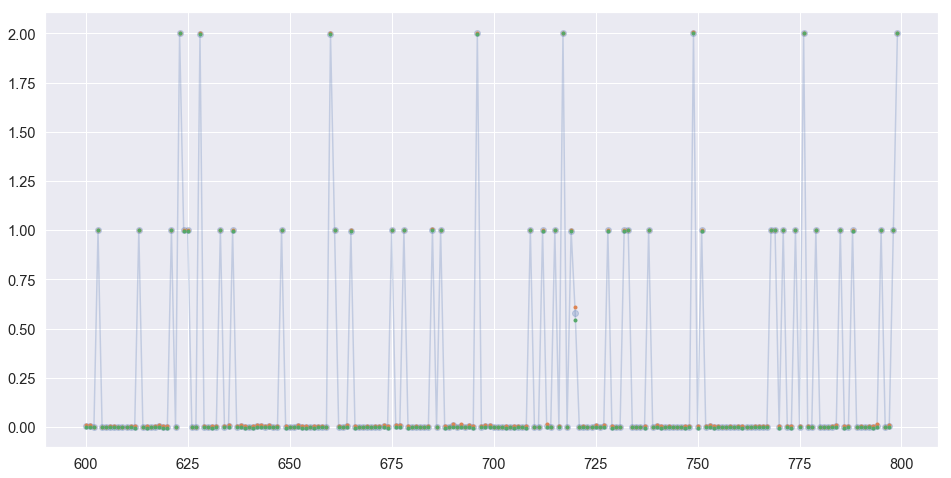

In [387]:

ax = []
for I in range(int(df_pop.shape[0]/200)):
    fig = plt.figure(figsize=(16, 8))
    ax_curr = fig.gca() #fig.add_subplot(int(df_pop.shape[0]/200), 1, I+1)
    ax.append(ax_curr)
    
    error_margin = \
        1.96*df_des_choices.loc["std",range(I*200, I*200+200)]/(df_pop.shape[0])**0.5
    
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)], 'o-', alpha=0.25)
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)] + error_margin,'.')
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)] - error_margin,'.')


In [388]:
df_choices[500].value_counts()

0    855
2      3
Name: 500, dtype: int64

In [389]:
df_choices[1].value_counts()

0    857
1      1
Name: 1, dtype: int64

In [390]:
fig = plt.figure()
plt.plot(des_choices.columns, des_choices.loc["min"])
ax = fig.gca()

#des_choices.loc["max"]

NameError: name 'des_choices' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
69000-85000

In [ ]:
16000/5000

In [ ]:
df_fam_cost

In [ ]:
16000/5000

## output

In [ ]:
submission_final